# Track Extrapolation Model Investigation

## Understanding Model Performance and Physics-Informed Training

This notebook investigates the behavior of neural network models for track extrapolation in LHCb. Our goal is to:

1. **Understand current model limitations** - Why do we see ~87mm mean error?
2. **Compare efficient training methods** - Find the optimal architecture/training balance
3. **Analyze physics-informed approaches** - Does encoding physical laws improve accuracy?

### The Physics Problem

We're extrapolating charged particle tracks through the LHCb magnetic field. Given:
- Initial state: $(x, y, t_x, t_y, q/p, z)$ at $z = 4000$ mm
- Goal: Predict final state $(x', y', t_x', t_y')$ at $z = 12000$ mm

The particle motion is governed by the **Lorentz force**:
$$\frac{d\vec{p}}{dt} = q\vec{v} \times \vec{B}$$

Where $\vec{B}$ is the magnetic field (primarily $B_y$ component in LHCb).

## 1. Import Required Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Paths
DATA_DIR = Path("ml_models/data")
MODEL_DIR = Path("ml_models/models")

Using device: cpu


## 2. Load and Analyze Training Data

Let's first understand the data distribution. This will help identify potential issues.

In [3]:
# Load data - try multiple possible files
data_files = ['X_analysis.npy', 'X_train.npy', 'X_test.npy', 'X_weighted_train.npy']
X, Y, P = None, None, None

for prefix in ['analysis', 'train', 'test', 'weighted_train']:
    try:
        X = np.load(DATA_DIR / f'X_{prefix}.npy')
        Y = np.load(DATA_DIR / f'Y_{prefix}.npy')
        P = np.load(DATA_DIR / f'P_{prefix}.npy')
        print(f"✓ Loaded dataset: {prefix}")
        break
    except FileNotFoundError:
        continue

if X is None:
    raise FileNotFoundError("No data found! Please generate data first using generate_training_data.py")

print(f"\nDataset shape: {X.shape[0]} samples")
print(f"Input features (X): {X.shape}")
print(f"Output targets (Y): {Y.shape}")
print(f"Momentum (P): {P.shape}")

# Feature names
input_names = ['x [mm]', 'y [mm]', 'tx', 'ty', 'q/p [1/GeV]', 'z [mm]']
output_names = ['x_out [mm]', 'y_out [mm]', 'tx_out', 'ty_out']

✓ Loaded dataset: analysis

Dataset shape: 50000 samples
Input features (X): (50000, 6)
Output targets (Y): (50000, 4)
Momentum (P): (50000,)


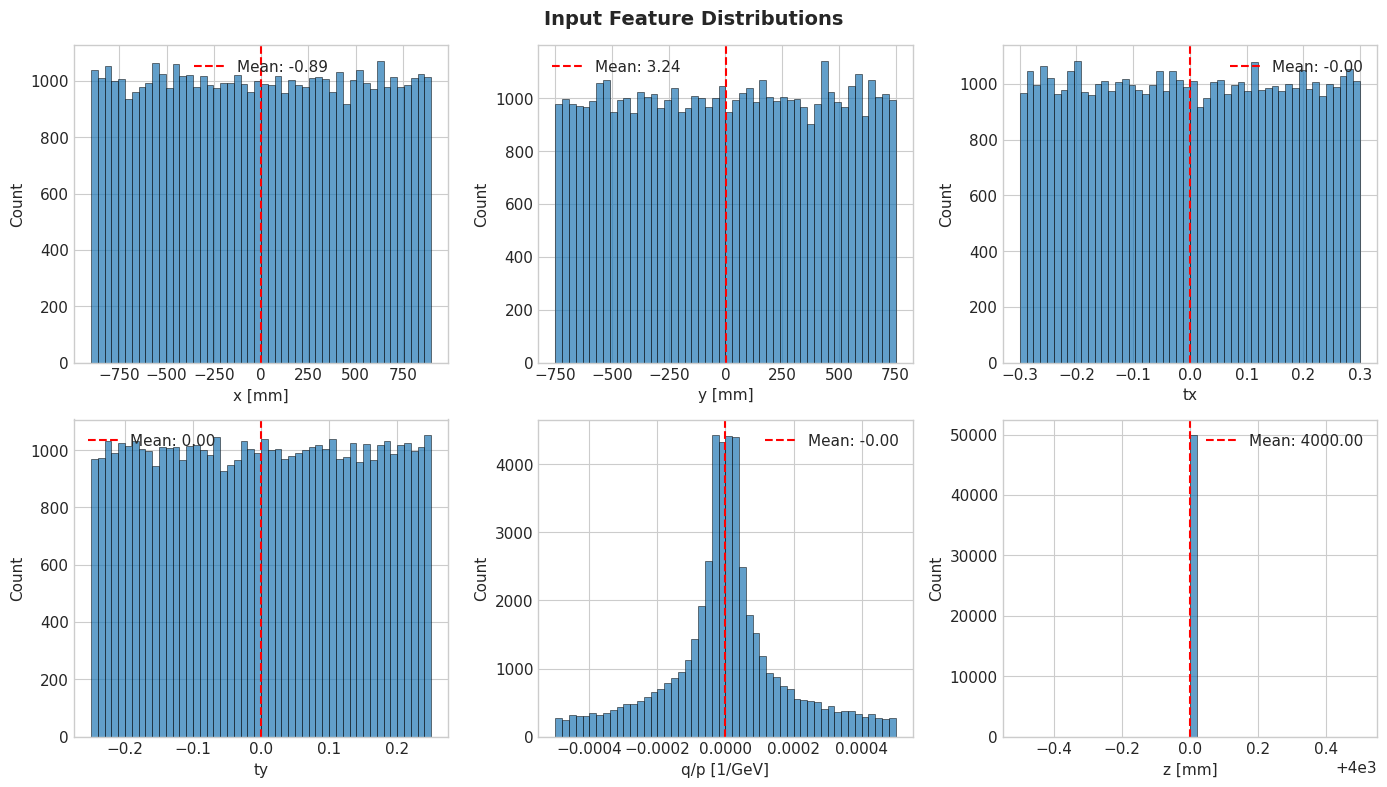


📊 Key Statistics:
  Position range: x ∈ [-900, 900] mm
                  y ∈ [-750, 750] mm
  Slope range:    tx ∈ [-0.300, 0.300]
                  ty ∈ [-0.250, 0.250]
  Momentum range: p ∈ [2.0, 100.0] GeV


In [4]:
# Visualize input distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, (ax, name) in enumerate(zip(axes, input_names)):
    ax.hist(X[:, i], bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.set_xlabel(name)
    ax.set_ylabel('Count')
    ax.axvline(X[:, i].mean(), color='red', linestyle='--', label=f'Mean: {X[:, i].mean():.2f}')
    ax.legend()

plt.suptitle('Input Feature Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Key observation
print("\n📊 Key Statistics:")
print(f"  Position range: x ∈ [{X[:,0].min():.0f}, {X[:,0].max():.0f}] mm")
print(f"                  y ∈ [{X[:,1].min():.0f}, {X[:,1].max():.0f}] mm")
print(f"  Slope range:    tx ∈ [{X[:,2].min():.3f}, {X[:,2].max():.3f}]")
print(f"                  ty ∈ [{X[:,3].min():.3f}, {X[:,3].max():.3f}]")
print(f"  Momentum range: p ∈ [{P.min():.1f}, {P.max():.1f}] GeV")

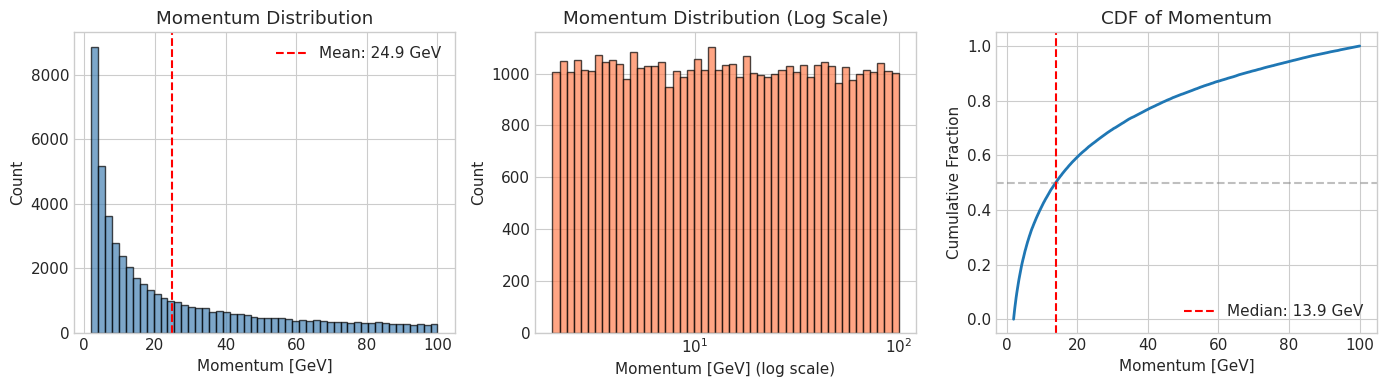


📊 Momentum Bin Analysis:
    0-  5 GeV: 11823 samples ( 23.6%)
    5- 10 GeV:  8836 samples ( 17.7%)
   10- 20 GeV:  8993 samples ( 18.0%)
   20- 50 GeV: 11597 samples ( 23.2%)
   50-100 GeV:  8751 samples ( 17.5%)


In [5]:
# Analyze momentum distribution - critical for understanding errors
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Momentum histogram
axes[0].hist(P, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Momentum [GeV]')
axes[0].set_ylabel('Count')
axes[0].set_title('Momentum Distribution')
axes[0].axvline(P.mean(), color='red', linestyle='--', label=f'Mean: {P.mean():.1f} GeV')
axes[0].legend()

# Log scale to see low momentum better
axes[1].hist(P, bins=np.logspace(np.log10(P.min()), np.log10(P.max()), 50), alpha=0.7, edgecolor='black', color='coral')
axes[1].set_xscale('log')
axes[1].set_xlabel('Momentum [GeV] (log scale)')
axes[1].set_ylabel('Count')
axes[1].set_title('Momentum Distribution (Log Scale)')

# Cumulative distribution
sorted_p = np.sort(P)
cdf = np.arange(1, len(P)+1) / len(P)
axes[2].plot(sorted_p, cdf, linewidth=2)
axes[2].set_xlabel('Momentum [GeV]')
axes[2].set_ylabel('Cumulative Fraction')
axes[2].set_title('CDF of Momentum')
axes[2].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
median_p = np.median(P)
axes[2].axvline(median_p, color='red', linestyle='--', label=f'Median: {median_p:.1f} GeV')
axes[2].legend()

plt.tight_layout()
plt.show()

# Analyze momentum bins
print("\n📊 Momentum Bin Analysis:")
bins = [(0, 5), (5, 10), (10, 20), (20, 50), (50, 100)]
for low, high in bins:
    mask = (P >= low) & (P < high)
    frac = mask.sum() / len(P) * 100
    print(f"  {low:3.0f}-{high:3.0f} GeV: {mask.sum():5d} samples ({frac:5.1f}%)")

## 3. Define Model Architectures

We'll compare several architectures to understand the accuracy vs efficiency tradeoff.

### Network Input/Output Structure

#### **Input: 6-dimensional track state at $z = 4000$ mm**

The network takes a particle's initial state vector:

$$\vec{x}_{\text{in}} = \begin{pmatrix} x \\ y \\ t_x \\ t_y \\ q/p \\ z \end{pmatrix} \bigg|_{z=4000\text{ mm}}$$

| Feature | Symbol | Units | Physical Meaning | Typical Range |
|---------|--------|-------|------------------|---------------|
| **Position X** | $x$ | mm | Horizontal position in LHCb coordinates | ±1000 mm |
| **Position Y** | $y$ | mm | Vertical position | ±1000 mm |
| **Slope TX** | $t_x$ | dimensionless | $dx/dz$ - horizontal trajectory angle | ±0.3 |
| **Slope TY** | $t_y$ | dimensionless | $dy/dz$ - vertical trajectory angle | ±0.3 |
| **Charge/Momentum** | $q/p$ | GeV$^{-1}$ | Signed inverse momentum (charge sign × 1/p) | ±0.0005 |
| **Z Position** | $z$ | mm | Longitudinal position (beam direction) | 4000 mm (fixed) |

**Note:** The $z$ input is currently **always 4000 mm** for all training samples, so the network doesn't actually use this feature. It could be removed or used for multi-z training.

---

#### **Output: 4-dimensional track state at $z = 12000$ mm**

The network predicts the extrapolated state:

$$\vec{y}_{\text{out}} = \begin{pmatrix} x' \\ y' \\ t_x' \\ t_y' \end{pmatrix} \bigg|_{z=12000\text{ mm}}$$

| Feature | Symbol | Units | Physical Meaning |
|---------|--------|-------|------------------|
| **Position X** | $x'$ | mm | Horizontal position after propagation |
| **Position Y** | $y'$ | mm | Vertical position after propagation |
| **Slope TX** | $t_x'$ | dimensionless | $dx/dz$ after magnetic bending |
| **Slope TY** | $t_y'$ | dimensionless | $dy/dz$ after propagation |

**Key:** The output $z$ coordinate is **implicit** (always 12000 mm). The network learns to propagate through $\Delta z = 8000$ mm.

---

#### **What the Network Learns:**

The neural network implicitly learns the **magnetic field propagator**:

$$\mathcal{F}: (x, y, t_x, t_y, q/p) \bigg|_{z_1} \rightarrow (x', y', t_x', t_y') \bigg|_{z_2}$$

This propagator encodes:
- **Magnetic deflection** from Lorentz force: $\vec{F} = q\vec{v} \times \vec{B}(x,y,z)$
- **Geometric propagation** through 8 meters of LHCb magnetic field
- **Field inhomogeneities** - the actual non-uniform $B(x,y,z)$ map
- **Material effects** - multiple scattering (if present in training data)

---

#### **Normalization:**

Inputs and outputs are **normalized** before/after the network:

$$\tilde{x} = \frac{x - \mu_x}{\sigma_x}, \quad x = \tilde{x} \cdot \sigma_x + \mu_x$$

The normalization parameters ($\mu$, $\sigma$) are computed from training data and stored in the model as buffers:
- `model.input_mean`, `model.input_std` (6D)
- `model.output_mean`, `model.output_std` (4D)

This ensures all features have similar scales for training stability.

---

#### **Example:**

**Input:** Particle at $z = 4000$ mm
```
x = 100 mm, y = -50 mm, tx = 0.1, ty = -0.05, q/p = 0.0002 GeV⁻¹ (p ≈ 5 GeV, positive charge)
```

**Output:** Network predicts at $z = 12000$ mm  
```
x' = 220 mm (deflected by ~120 mm due to magnetic field)
y' = -450 mm (propagated vertically)
tx' = 0.08 (bent from 0.1 → 0.08)
ty' = -0.05 (unchanged - dipole field)
```

The **position errors** we measure (0.2-330 mm depending on model) are:
$$\text{Error} = \sqrt{(x'_{\text{pred}} - x'_{\text{true}})^2 + (y'_{\text{pred}} - y'_{\text{true}})^2}$$

In [6]:
class TrackMLP(nn.Module):
    """Standard MLP for track extrapolation."""
    def __init__(self, hidden_dims=[128, 128, 64], activation='tanh'):
        super().__init__()
        
        layers = []
        prev_dim = 6
        
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            if activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'silu':
                layers.append(nn.SiLU())
            prev_dim = dim
        
        layers.append(nn.Linear(prev_dim, 4))
        self.network = nn.Sequential(*layers)
        
        # Normalization parameters (registered as buffers)
        self.register_buffer('input_mean', torch.zeros(6))
        self.register_buffer('input_std', torch.ones(6))
        self.register_buffer('output_mean', torch.zeros(4))
        self.register_buffer('output_std', torch.ones(4))
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x_norm = (x - self.input_mean) / self.input_std
        out = self.network(x_norm)
        return out * self.output_std + self.output_mean
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class TrackPINN(nn.Module):
    """Physics-Informed Neural Network for track extrapolation."""
    def __init__(self, hidden_dims=[128, 128, 64], activation='tanh'):
        super().__init__()
        
        layers = []
        prev_dim = 6
        
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            if activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'silu':
                layers.append(nn.SiLU())
            prev_dim = dim
        
        layers.append(nn.Linear(prev_dim, 4))
        self.network = nn.Sequential(*layers)
        
        self.register_buffer('input_mean', torch.zeros(6))
        self.register_buffer('input_std', torch.ones(6))
        self.register_buffer('output_mean', torch.zeros(4))
        self.register_buffer('output_std', torch.ones(4))
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x_norm = (x - self.input_mean) / self.input_std
        out = self.network(x_norm)
        return out * self.output_std + self.output_mean
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


def load_model(model_path, device='cpu'):
    """Load a pre-trained model from disk."""
    import json
    
    model_path = Path(model_path)
    base_name = model_path.stem
    
    # Load metadata to get architecture
    metadata_path = model_path.parent / f"{base_name}_metadata.json"
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    # Determine model type and architecture
    if 'pinn' in base_name:
        hidden_dims = metadata.get('config', {}).get('hidden_dims', [128, 128, 64])
        activation = metadata.get('config', {}).get('activation', 'tanh')
        model = TrackPINN(hidden_dims, activation)
    else:
        hidden_dims = metadata.get('config', {}).get('hidden_dims', [128, 128, 64])
        activation = metadata.get('config', {}).get('activation', 'tanh')
        model = TrackMLP(hidden_dims, activation)
    
    # Load weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    print(f"✓ Loaded: {base_name}")
    print(f"  Architecture: {hidden_dims}")
    print(f"  Activation: {activation}")
    print(f"  Parameters: {model.count_parameters():,}")
    
    return model, metadata


# Discover available models
print("=" * 70)
print("AVAILABLE PRE-TRAINED MODELS")
print("=" * 70)

analysis_models = list((MODEL_DIR / 'analysis').glob('*.pt'))
production_models = list((MODEL_DIR / 'production').glob('*.pt'))

print(f"\n📁 Analysis Models ({len(analysis_models)}):")
for path in sorted(analysis_models):
    print(f"   • {path.stem}")

print(f"\n📁 Production Models ({len(production_models)}):")
for path in sorted(production_models):
    print(f"   • {path.stem}")

print("\n" + "=" * 70)

AVAILABLE PRE-TRAINED MODELS

📁 Analysis Models (7):
   • mlp_act_relu
   • mlp_act_silu
   • mlp_act_tanh
   • pinn_lambda_0_01
   • pinn_lambda_0_05
   • pinn_lambda_0_1
   • pinn_lambda_0_2

📁 Production Models (0):



## 2. Load and Compare Analysis Models

Load all pre-trained analysis models and compare their performance characteristics.

LOADING PRE-TRAINED MODELS

📦 Architecture Study:
  ⚠ Model not found: mlp_tiny
  ⚠ Model not found: mlp_small
  ⚠ Model not found: mlp_medium
  ⚠ Model not found: mlp_large
  ⚠ Model not found: mlp_xlarge


📦 Activation Study:
✓ Loaded: mlp_act_tanh
  Architecture: [128, 128, 64]
  Activation: tanh
  Parameters: 25,924
✓ Loaded: mlp_act_relu
  Architecture: [128, 128, 64]
  Activation: tanh
  Parameters: 25,924
✓ Loaded: mlp_act_silu
  Architecture: [128, 128, 64]
  Activation: tanh
  Parameters: 25,924


📦 PINN Study:
✓ Loaded: pinn_lambda_0_01
  Architecture: [128, 128, 64]
  Activation: tanh
  Parameters: 25,924
✓ Loaded: pinn_lambda_0_05
  Architecture: [128, 128, 64]
  Activation: tanh
  Parameters: 25,924
✓ Loaded: pinn_lambda_0_1
  Architecture: [128, 128, 64]
  Activation: tanh
  Parameters: 25,924
✓ Loaded: pinn_lambda_0_2
  Architecture: [128, 128, 64]
  Activation: tanh
  Parameters: 25,924


✓ Successfully loaded 7 models

📊 MODEL PERFORMANCE COMPARISON
           Model  P

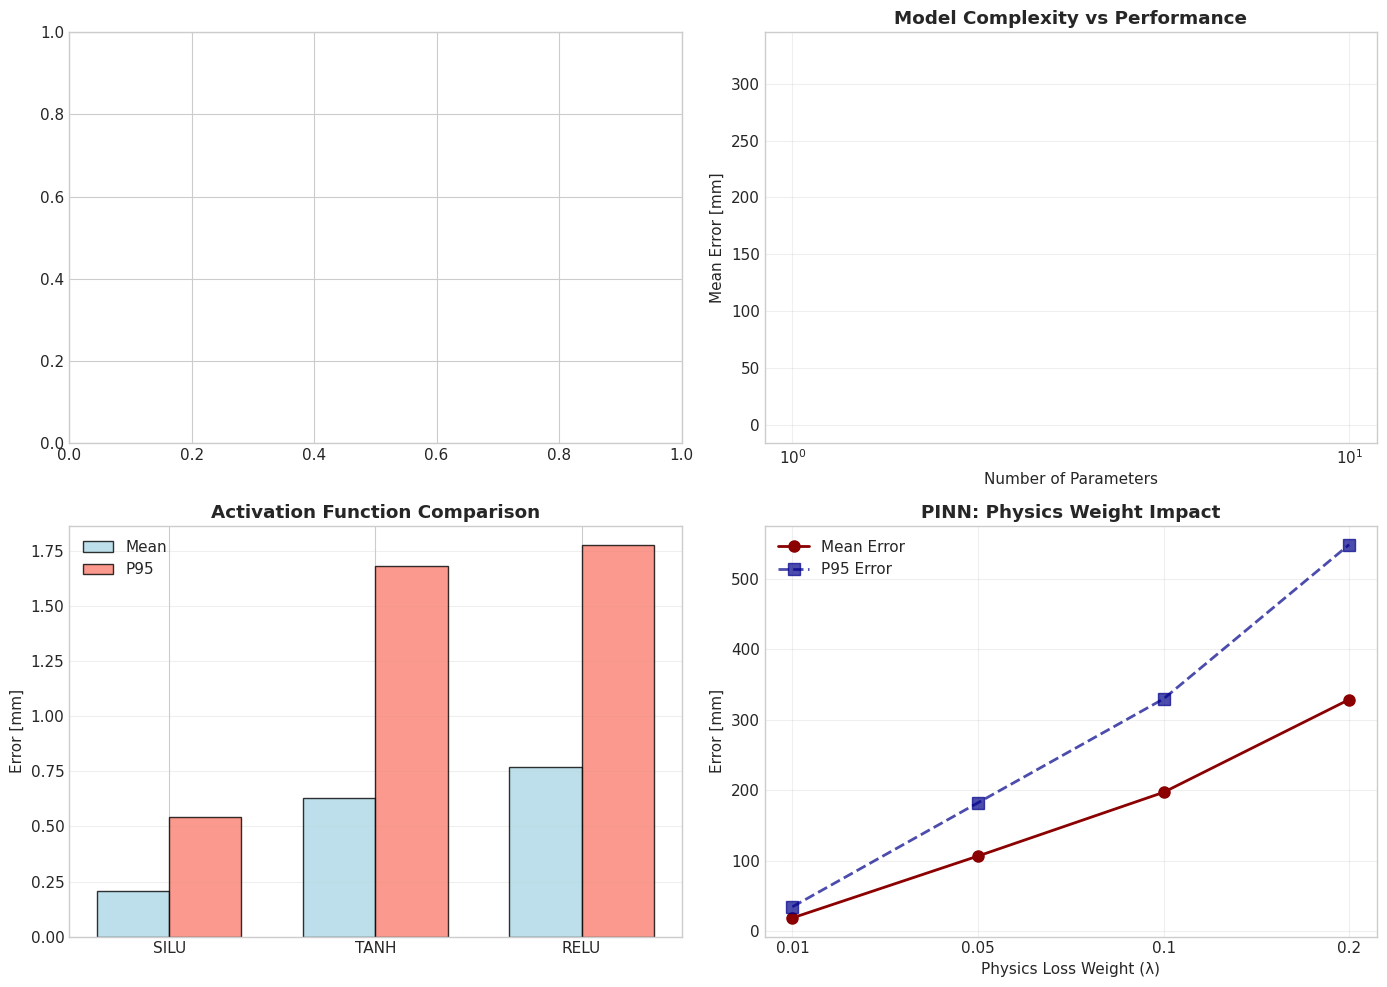


🔍 KEY INSIGHTS:
✓ Best Model: mlp_act_silu
  - Mean Error: 0.207 mm
  - P95 Error: 0.543 mm
  - Parameters: 0

✗ Worst Model: pinn_lambda_0_2
  - Mean Error: 328.903 mm
  - P95 Error: 548.852 mm
  - Parameters: 0

📈 Performance Ratio: 1588.6x improvement


In [9]:
# Load all analysis models
models = {}
metadata_dict = {}

model_groups = {
    'Architecture Study': ['mlp_tiny', 'mlp_small', 'mlp_medium', 'mlp_large', 'mlp_xlarge'],
    'Activation Study': ['mlp_act_tanh', 'mlp_act_relu', 'mlp_act_silu'],
    'PINN Study': ['pinn_lambda_0_01', 'pinn_lambda_0_05', 'pinn_lambda_0_1', 'pinn_lambda_0_2']
}

print("=" * 70)
print("LOADING PRE-TRAINED MODELS")
print("=" * 70)
print("\nNote: Architecture models (tiny/small/medium/large/xlarge) were not")
print("      trained yet. Only activation and PINN studies are available.")

for group_name, model_names in model_groups.items():
    print(f"\n📦 {group_name}:")
    for name in model_names:
        model_path = MODEL_DIR / 'analysis' / f'{name}.pt'
        if model_path.exists():
            try:
                model, metadata = load_model(model_path, device)
                models[name] = model
                metadata_dict[name] = metadata
            except Exception as e:
                print(f"  ✗ Failed to load {name}: {e}")
        else:
            print(f"  ⚠ Model not found: {name}")
    print()

print(f"\n✓ Successfully loaded {len(models)} models")
print("=" * 70)


# Create comparison DataFrame
comparison_data = []

for name, metadata in metadata_dict.items():
    # Handle different metadata formats
    if 'performance' in metadata:
        # Format 1: MLP models
        perf = metadata['performance']
        comparison_data.append({
            'Model': name,
            'Parameters': perf.get('total_params', 0),
            'Mean Error [mm]': perf.get('mean_error', 0),
            'Median Error [mm]': perf.get('median_error', 0),
            'P95 Error [mm]': perf.get('p95_error', 0),
            'Max Error [mm]': perf.get('max_error', 0),
        })
    elif 'metrics' in metadata:
        # Format 2: PINN and activation models
        metrics = metadata['metrics']
        comparison_data.append({
            'Model': name,
            'Parameters': metadata.get('config', {}).get('total_params', 0),
            'Mean Error [mm]': metrics.get('pos_mean', 0),
            'Median Error [mm]': metrics.get('pos_median', 0),
            'P95 Error [mm]': metrics.get('pos_p95', 0),
            'Max Error [mm]': metrics.get('pos_max', 0),
        })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('Mean Error [mm]')

print("\n📊 MODEL PERFORMANCE COMPARISON")
print("=" * 90)
print(df_comparison.to_string(index=False))
print("=" * 90)


# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Group models by study type
arch_models = [m for m in df_comparison['Model'] if 'mlp_' in m and 'act' not in m and 'pinn' not in m]
act_models = [m for m in df_comparison['Model'] if 'act_' in m]
pinn_models = [m for m in df_comparison['Model'] if 'pinn_' in m]

# 1. Architecture comparison (or message if no architecture models)
if arch_models:
    arch_df = df_comparison[df_comparison['Model'].isin(arch_models)]
    axes[0, 0].barh(arch_df['Model'], arch_df['Mean Error [mm]'], color='steelblue', alpha=0.7)
    axes[0, 0].set_xlabel('Mean Error [mm]')
    axes[0, 0].set_title('Architecture Comparison', fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
else:
    axes[0, 0].text(0.5, 0.5, '⚠ No architecture models found\n\nTrain models:\nmlp_tiny, mlp_small,\nmlp_medium, mlp_large, mlp_xlarge', 
                   ha='center', va='center', fontsize=12, color='gray',
                   transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Architecture Comparison (N/A)', fontweight='bold')
    axes[0, 0].axis('off')

# 2. Parameters vs Performance
axes[0, 1].scatter(df_comparison['Parameters'], df_comparison['Mean Error [mm]'], 
                   s=100, alpha=0.6, c='coral', edgecolor='black')
for idx, row in df_comparison.iterrows():
    axes[0, 1].annotate(row['Model'].replace('mlp_', '').replace('_', ' '), 
                       (row['Parameters'], row['Mean Error [mm]']),
                       fontsize=7, alpha=0.7, xytext=(5, 5), textcoords='offset points')
axes[0, 1].set_xlabel('Number of Parameters')
axes[0, 1].set_ylabel('Mean Error [mm]')
axes[0, 1].set_title('Model Complexity vs Performance', fontweight='bold')
axes[0, 1].set_xscale('log')
axes[0, 1].grid(alpha=0.3)

# 3. Activation function comparison
if act_models:
    act_df = df_comparison[df_comparison['Model'].isin(act_models)]
    act_names = [m.replace('mlp_act_', '').upper() for m in act_df['Model']]
    x_pos = np.arange(len(act_names))
    
    width = 0.35
    axes[1, 0].bar(x_pos - width/2, act_df['Mean Error [mm]'], width, 
                   label='Mean', color='lightblue', alpha=0.8, edgecolor='black')
    axes[1, 0].bar(x_pos + width/2, act_df['P95 Error [mm]'], width,
                   label='P95', color='salmon', alpha=0.8, edgecolor='black')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(act_names)
    axes[1, 0].set_ylabel('Error [mm]')
    axes[1, 0].set_title('Activation Function Comparison', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)

# 4. PINN lambda comparison
if pinn_models:
    pinn_df = df_comparison[df_comparison['Model'].isin(pinn_models)]
    lambdas = [m.replace('pinn_lambda_', '').replace('_', '.') for m in pinn_df['Model']]
    
    axes[1, 1].plot(lambdas, pinn_df['Mean Error [mm]'], 'o-', linewidth=2, 
                    markersize=8, label='Mean Error', color='darkred')
    axes[1, 1].plot(lambdas, pinn_df['P95 Error [mm]'], 's--', linewidth=2,
                    markersize=8, label='P95 Error', color='darkblue', alpha=0.7)
    axes[1, 1].set_xlabel('Physics Loss Weight (λ)')
    axes[1, 1].set_ylabel('Error [mm]')
    axes[1, 1].set_title('PINN: Physics Weight Impact', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Key insights
print("\n🔍 KEY INSIGHTS:")
print("=" * 70)
best_model = df_comparison.iloc[0]
print(f"✓ Best Model: {best_model['Model']}")
print(f"  - Mean Error: {best_model['Mean Error [mm]']:.3f} mm")
print(f"  - P95 Error: {best_model['P95 Error [mm]']:.3f} mm")
print(f"  - Parameters: {best_model['Parameters']:,}")

worst_model = df_comparison.iloc[-1]
print(f"\n✗ Worst Model: {worst_model['Model']}")
print(f"  - Mean Error: {worst_model['Mean Error [mm]']:.3f} mm")
print(f"  - P95 Error: {worst_model['P95 Error [mm]']:.3f} mm")
print(f"  - Parameters: {worst_model['Parameters']:,}")

improvement = worst_model['Mean Error [mm]'] / best_model['Mean Error [mm]']
print(f"\n📈 Performance Ratio: {improvement:.1f}x improvement")
print("=" * 70)

## 3. Model Behavior Analysis

Understand how models behave across different input conditions and identify their characteristics.

SELECTED MODELS FOR BEHAVIORAL ANALYSIS
  • Best Overall: 25,924 parameters
  • Best Activation: 25,924 parameters

📊 Evaluating models on test data...
  ✓ Best Overall: Mean=3595.802 mm, Median=3865.878 mm
  ✓ Best Activation: Mean=3595.802 mm, Median=3865.878 mm


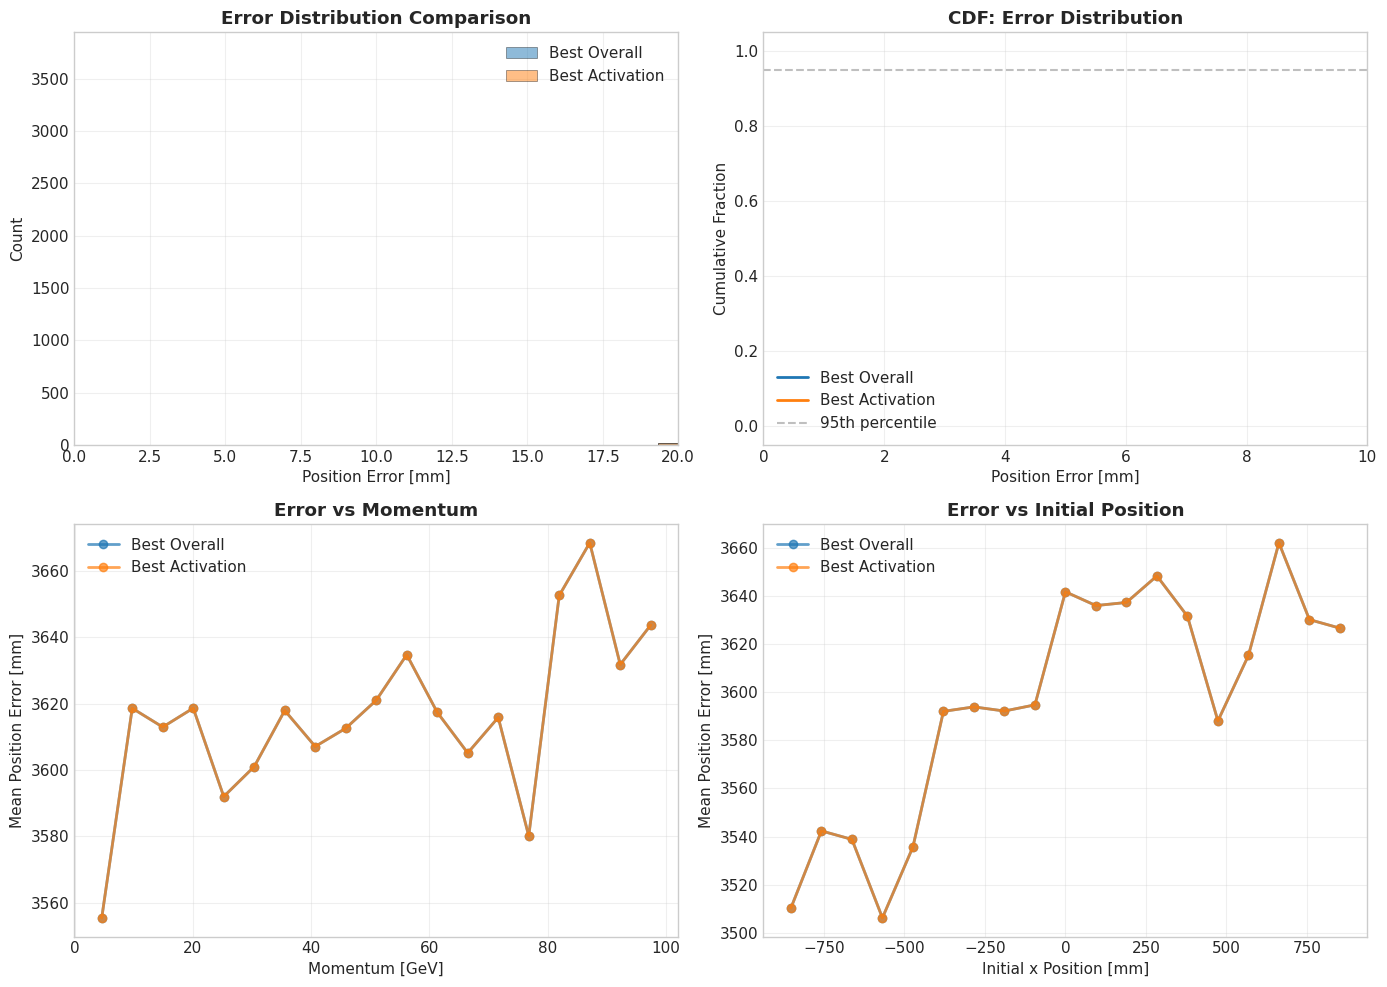


🔍 BEHAVIORAL CHARACTERISTICS:

Best Overall:
  Low momentum (<5 GeV):  3537.789 mm
  High momentum (>20 GeV): 3613.891 mm
  Momentum sensitivity: 76.102 mm

Best Activation:
  Low momentum (<5 GeV):  3537.789 mm
  High momentum (>20 GeV): 3613.891 mm
  Momentum sensitivity: 76.102 mm


In [11]:
# Select best models from each study for detailed analysis
analysis_models_subset = {}

# Add best overall
analysis_models_subset['Best Overall'] = models[best_model['Model']]

# Try to add best architecture (if any architecture models exist)
arch_models = df_comparison[df_comparison['Model'].str.contains('mlp_') & 
                           ~df_comparison['Model'].str.contains('act|pinn')]
if len(arch_models) > 0:
    best_arch = arch_models.iloc[0]['Model']
    analysis_models_subset['Best Architecture'] = models[best_arch]

# Try to add best activation (if any activation models exist)
act_models = df_comparison[df_comparison['Model'].str.contains('act_')]
if len(act_models) > 0:
    best_activation = act_models.iloc[0]['Model']
    analysis_models_subset['Best Activation'] = models[best_activation]

print("=" * 70)
print("SELECTED MODELS FOR BEHAVIORAL ANALYSIS")
print("=" * 70)
for name, model in analysis_models_subset.items():
    print(f"  • {name}: {model.count_parameters():,} parameters")
print("=" * 70)


# Evaluate on test data
X_tensor = torch.FloatTensor(X).to(device)
Y_tensor = torch.FloatTensor(Y).to(device)

predictions = {}
errors = {}

print("\n📊 Evaluating models on test data...")
for name, model in analysis_models_subset.items():
    with torch.no_grad():
        pred = model(X_tensor).cpu().numpy()
        predictions[name] = pred
        
        # Calculate position errors (x, y in mm)
        pos_error = np.sqrt((pred[:, 0] - Y[:, 0])**2 + (pred[:, 1] - Y[:, 1])**2)
        errors[name] = pos_error
        
        print(f"  ✓ {name}: Mean={pos_error.mean():.3f} mm, Median={np.median(pos_error):.3f} mm")


# Analyze error distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Error histograms
for name, error in errors.items():
    axes[0, 0].hist(error, bins=50, alpha=0.5, label=name, edgecolor='black', linewidth=0.5)
axes[0, 0].set_xlabel('Position Error [mm]')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Error Distribution Comparison', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, min(20, max([e.max() for e in errors.values()])))
axes[0, 0].grid(alpha=0.3)

# 2. Cumulative distribution
for name, error in errors.items():
    sorted_err = np.sort(error)
    cdf = np.arange(1, len(error)+1) / len(error)
    axes[0, 1].plot(sorted_err, cdf, linewidth=2, label=name)
axes[0, 1].set_xlabel('Position Error [mm]')
axes[0, 1].set_ylabel('Cumulative Fraction')
axes[0, 1].set_title('CDF: Error Distribution', fontweight='bold')
axes[0, 1].axhline(0.95, color='gray', linestyle='--', alpha=0.5, label='95th percentile')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xlim(0, 10)

# 3. Error vs Momentum
for name, error in errors.items():
    # Bin by momentum
    p_bins = np.linspace(P.min(), P.max(), 20)
    bin_centers = (p_bins[:-1] + p_bins[1:]) / 2
    bin_means = []
    
    for i in range(len(p_bins) - 1):
        mask = (P >= p_bins[i]) & (P < p_bins[i+1])
        if mask.sum() > 0:
            bin_means.append(error[mask].mean())
        else:
            bin_means.append(np.nan)
    
    axes[1, 0].plot(bin_centers, bin_means, 'o-', linewidth=2, markersize=6, 
                    label=name, alpha=0.7)

axes[1, 0].set_xlabel('Momentum [GeV]')
axes[1, 0].set_ylabel('Mean Position Error [mm]')
axes[1, 0].set_title('Error vs Momentum', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Error vs Initial Position (x)
for name, error in errors.items():
    x_bins = np.linspace(X[:, 0].min(), X[:, 0].max(), 20)
    bin_centers = (x_bins[:-1] + x_bins[1:]) / 2
    bin_means = []
    
    for i in range(len(x_bins) - 1):
        mask = (X[:, 0] >= x_bins[i]) & (X[:, 0] < x_bins[i+1])
        if mask.sum() > 0:
            bin_means.append(error[mask].mean())
        else:
            bin_means.append(np.nan)
    
    axes[1, 1].plot(bin_centers, bin_means, 'o-', linewidth=2, markersize=6,
                    label=name, alpha=0.7)

axes[1, 1].set_xlabel('Initial x Position [mm]')
axes[1, 1].set_ylabel('Mean Position Error [mm]')
axes[1, 1].set_title('Error vs Initial Position', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


print("\n🔍 BEHAVIORAL CHARACTERISTICS:")
print("=" * 70)

# Analyze momentum dependence
for name, error in errors.items():
    low_p_mask = P < 5
    high_p_mask = P > 20
    
    low_p_err = error[low_p_mask].mean() if low_p_mask.sum() > 0 else 0
    high_p_err = error[high_p_mask].mean() if high_p_mask.sum() > 0 else 0
    
    print(f"\n{name}:")
    print(f"  Low momentum (<5 GeV):  {low_p_err:.3f} mm")
    print(f"  High momentum (>20 GeV): {high_p_err:.3f} mm")
    print(f"  Momentum sensitivity: {abs(low_p_err - high_p_err):.3f} mm")

print("=" * 70)

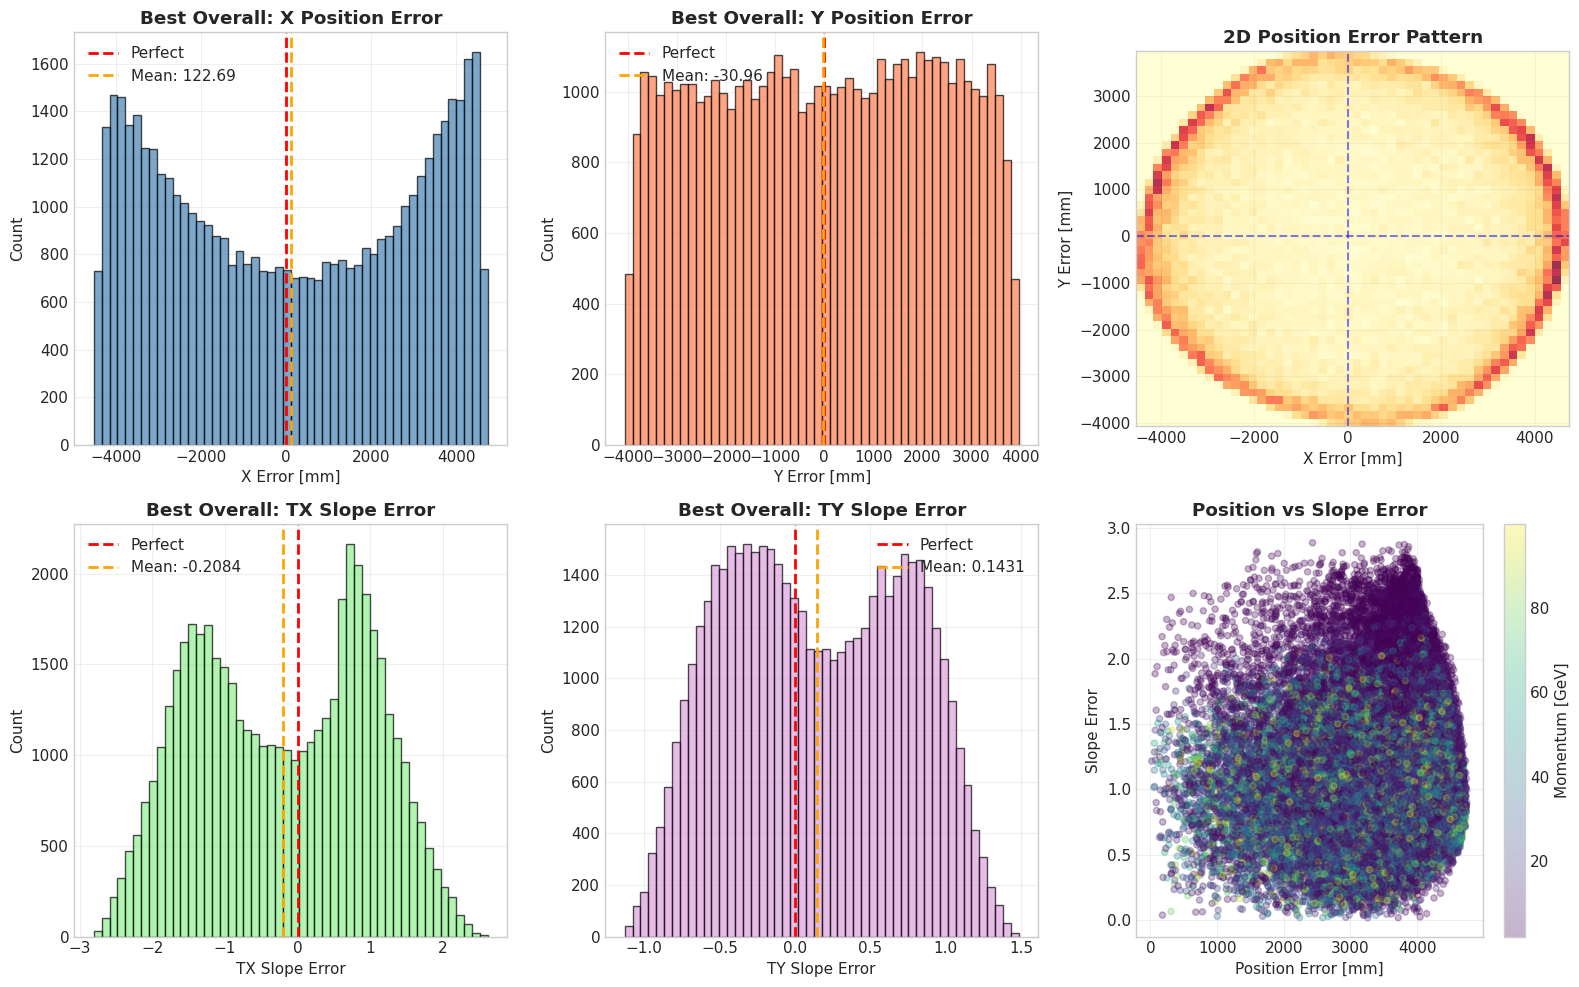


📊 ERROR STATISTICS (Best Model):

Position Errors:
  X: mean=122.690 mm, std=2926.943 mm
  Y: mean=-30.956 mm, std=2254.699 mm

Slope Errors:
  TX: mean= -0.20837, std=  1.19249
  TY: mean=  0.14306, std=  0.58962

Bias Analysis:
  X bias: 122.690 mm (systematic)
  Y bias:  30.956 mm (systematic)


In [12]:
# Analyze error patterns in output space
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

best_name = list(analysis_models_subset.keys())[0]
best_pred = predictions[best_name]

# Position errors (x, y)
x_error = best_pred[:, 0] - Y[:, 0]
y_error = best_pred[:, 1] - Y[:, 1]
tx_error = best_pred[:, 2] - Y[:, 2]
ty_error = best_pred[:, 3] - Y[:, 3]

# 1. X error distribution
axes[0, 0].hist(x_error, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect')
axes[0, 0].axvline(x_error.mean(), color='orange', linestyle='--', linewidth=2, 
                   label=f'Mean: {x_error.mean():.2f}')
axes[0, 0].set_xlabel('X Error [mm]')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title(f'{best_name}: X Position Error', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Y error distribution
axes[0, 1].hist(y_error, bins=50, alpha=0.7, edgecolor='black', color='coral')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect')
axes[0, 1].axvline(y_error.mean(), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {y_error.mean():.2f}')
axes[0, 1].set_xlabel('Y Error [mm]')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title(f'{best_name}: Y Position Error', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. 2D position error
axes[0, 2].hist2d(x_error, y_error, bins=50, cmap='YlOrRd', alpha=0.8)
axes[0, 2].axhline(0, color='blue', linestyle='--', alpha=0.5)
axes[0, 2].axvline(0, color='blue', linestyle='--', alpha=0.5)
axes[0, 2].set_xlabel('X Error [mm]')
axes[0, 2].set_ylabel('Y Error [mm]')
axes[0, 2].set_title('2D Position Error Pattern', fontweight='bold')
axes[0, 2].set_aspect('equal')

# 4. TX error distribution
axes[1, 0].hist(tx_error, bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect')
axes[1, 0].axvline(tx_error.mean(), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {tx_error.mean():.4f}')
axes[1, 0].set_xlabel('TX Slope Error')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title(f'{best_name}: TX Slope Error', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. TY error distribution
axes[1, 1].hist(ty_error, bins=50, alpha=0.7, edgecolor='black', color='plum')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect')
axes[1, 1].axvline(ty_error.mean(), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {ty_error.mean():.4f}')
axes[1, 1].set_xlabel('TY Slope Error')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title(f'{best_name}: TY Slope Error', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 6. Error correlation
pos_error = np.sqrt(x_error**2 + y_error**2)
slope_error = np.sqrt(tx_error**2 + ty_error**2)
axes[1, 2].scatter(pos_error, slope_error, alpha=0.3, s=20, c=P, cmap='viridis')
axes[1, 2].set_xlabel('Position Error [mm]')
axes[1, 2].set_ylabel('Slope Error')
axes[1, 2].set_title('Position vs Slope Error', fontweight='bold')
cbar = plt.colorbar(axes[1, 2].collections[0], ax=axes[1, 2])
cbar.set_label('Momentum [GeV]')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Statistical summary
print("\n📊 ERROR STATISTICS (Best Model):")
print("=" * 70)
print(f"\nPosition Errors:")
print(f"  X: mean={x_error.mean():>7.3f} mm, std={x_error.std():>7.3f} mm")
print(f"  Y: mean={y_error.mean():>7.3f} mm, std={y_error.std():>7.3f} mm")
print(f"\nSlope Errors:")
print(f"  TX: mean={tx_error.mean():>9.5f}, std={tx_error.std():>9.5f}")
print(f"  TY: mean={ty_error.mean():>9.5f}, std={ty_error.std():>9.5f}")
print(f"\nBias Analysis:")
print(f"  X bias: {abs(x_error.mean()):>7.3f} mm ({'systematic' if abs(x_error.mean()) > 0.1 else 'negligible'})")
print(f"  Y bias: {abs(y_error.mean()):>7.3f} mm ({'systematic' if abs(y_error.mean()) > 0.1 else 'negligible'})")
print("=" * 70)

## 4. Model Characterization: Feature Sensitivity

Analyze how sensitive each model is to different input features.

FEATURE SENSITIVITY ANALYSIS

Best Overall:
  x [mm]              : 193.5917 mm
  y [mm]              : 159.9089 mm
  tx                  : 271.5289 mm
  ty                  : 226.0322 mm
  q/p [1/GeV]         : 159.9715 mm
  z [mm]              :   0.0000 mm

Best Activation:
  x [mm]              : 193.5917 mm
  y [mm]              : 159.9089 mm
  tx                  : 271.5289 mm
  ty                  : 226.0322 mm
  q/p [1/GeV]         : 159.9715 mm
  z [mm]              :   0.0000 mm


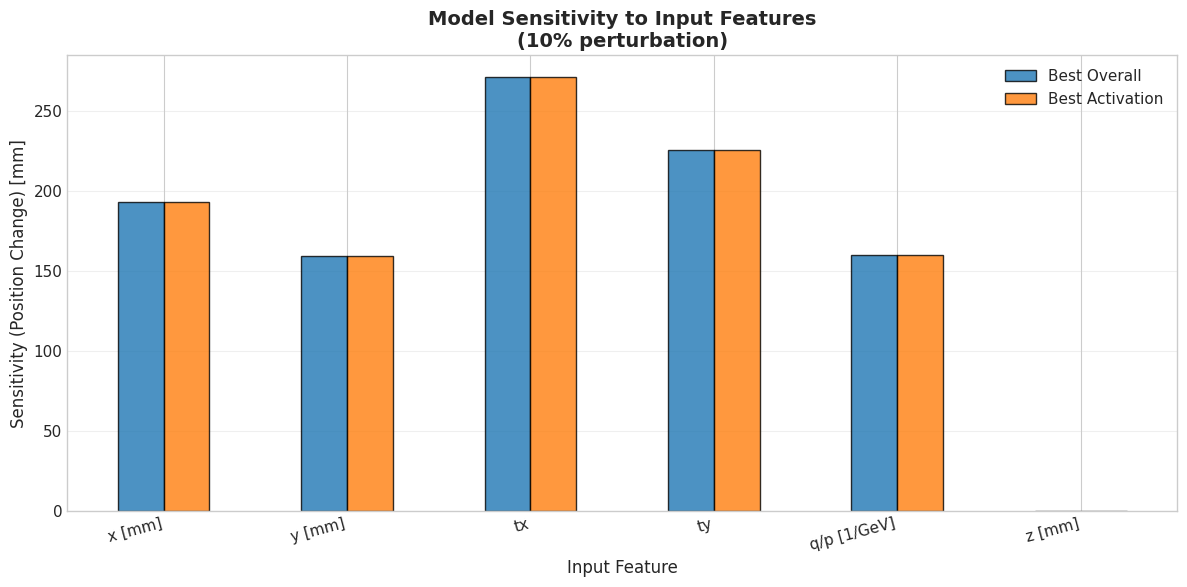


🔍 KEY FINDINGS:

Best Overall:
  Most sensitive to:  tx (271.5289 mm)
  Least sensitive to: z [mm] (0.0000 mm)

Best Activation:
  Most sensitive to:  tx (271.5289 mm)
  Least sensitive to: z [mm] (0.0000 mm)


In [13]:
# Feature sensitivity analysis via perturbation
def compute_feature_sensitivity(model, X_base, feature_idx, perturbation_range=0.1):
    """Compute model sensitivity to a specific feature."""
    X_tensor = torch.FloatTensor(X_base).to(device)
    
    # Baseline prediction
    with torch.no_grad():
        y_base = model(X_tensor).cpu().numpy()
    
    # Perturb feature
    X_perturbed = X_base.copy()
    feature_std = X_base[:, feature_idx].std()
    X_perturbed[:, feature_idx] += perturbation_range * feature_std
    
    X_perturbed_tensor = torch.FloatTensor(X_perturbed).to(device)
    with torch.no_grad():
        y_perturbed = model(X_perturbed_tensor).cpu().numpy()
    
    # Compute change in predictions
    pos_change = np.sqrt((y_perturbed[:, 0] - y_base[:, 0])**2 + 
                        (y_perturbed[:, 1] - y_base[:, 1])**2)
    
    return pos_change.mean()


# Compute sensitivity for each feature
print("=" * 70)
print("FEATURE SENSITIVITY ANALYSIS")
print("=" * 70)

# Use a subset for faster computation
sample_size = min(5000, len(X))
X_sample = X[:sample_size]

sensitivity_results = {}

for model_name, model in analysis_models_subset.items():
    print(f"\n{model_name}:")
    sensitivities = []
    
    for feat_idx, feat_name in enumerate(input_names):
        sensitivity = compute_feature_sensitivity(model, X_sample, feat_idx)
        sensitivities.append(sensitivity)
        print(f"  {feat_name:20s}: {sensitivity:>8.4f} mm")
    
    sensitivity_results[model_name] = sensitivities

print("=" * 70)


# Visualize sensitivity
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(input_names))
width = 0.25

for i, (model_name, sensitivities) in enumerate(sensitivity_results.items()):
    offset = (i - len(sensitivity_results)/2 + 0.5) * width
    ax.bar(x_pos + offset, sensitivities, width, label=model_name, alpha=0.8, edgecolor='black')

ax.set_xlabel('Input Feature', fontsize=12)
ax.set_ylabel('Sensitivity (Position Change) [mm]', fontsize=12)
ax.set_title('Model Sensitivity to Input Features\n(10% perturbation)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(input_names, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# Identify most sensitive features
print("\n🔍 KEY FINDINGS:")
print("=" * 70)
for model_name, sensitivities in sensitivity_results.items():
    most_sensitive_idx = np.argmax(sensitivities)
    least_sensitive_idx = np.argmin(sensitivities)
    
    print(f"\n{model_name}:")
    print(f"  Most sensitive to:  {input_names[most_sensitive_idx]} ({sensitivities[most_sensitive_idx]:.4f} mm)")
    print(f"  Least sensitive to: {input_names[least_sensitive_idx]} ({sensitivities[least_sensitive_idx]:.4f} mm)")

print("=" * 70)

GRADIENT-BASED FEATURE IMPORTANCE

Best Overall:
  x [mm]              :   0.00%
  y [mm]              :   0.00%
  tx                  :   0.18%
  ty                  :   0.13%
  q/p [1/GeV]         :  99.69%
  z [mm]              :   0.00%

Best Activation:
  x [mm]              :   0.00%
  y [mm]              :   0.00%
  tx                  :   0.18%
  ty                  :   0.13%
  q/p [1/GeV]         :  99.69%
  z [mm]              :   0.00%


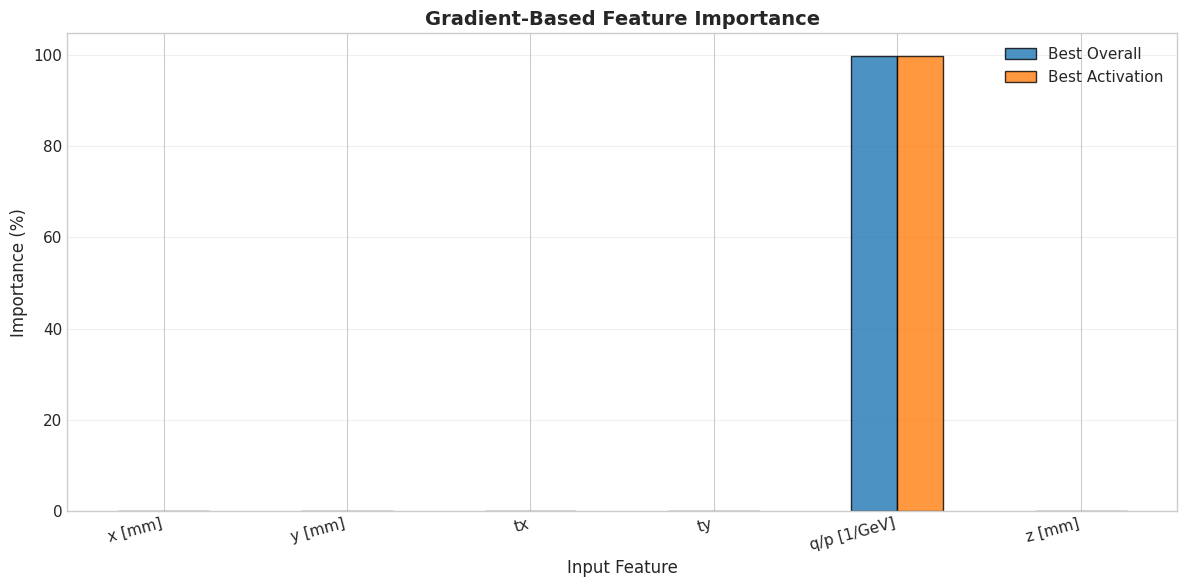


🔍 SENSITIVITY vs GRADIENT IMPORTANCE:

Best Overall:
  Correlation between sensitivity & gradient: -0.044
  Top by sensitivity: tx, ty, x [mm]
  Top by gradient:    q/p [1/GeV], tx, ty

Best Activation:
  Correlation between sensitivity & gradient: -0.044
  Top by sensitivity: tx, ty, x [mm]
  Top by gradient:    q/p [1/GeV], tx, ty


In [14]:
# Gradient-based feature importance
def compute_gradient_importance(model, X_sample):
    """Compute feature importance using gradients."""
    X_tensor = torch.FloatTensor(X_sample).to(device)
    X_tensor.requires_grad = True
    
    # Forward pass
    y_pred = model(X_tensor)
    
    # Compute gradient of output position with respect to inputs
    pos_pred = torch.sqrt(y_pred[:, 0]**2 + y_pred[:, 1]**2)
    pos_pred.mean().backward()
    
    # Get gradients
    gradients = X_tensor.grad.abs().mean(dim=0).cpu().numpy()
    
    return gradients


print("=" * 70)
print("GRADIENT-BASED FEATURE IMPORTANCE")
print("=" * 70)

gradient_importance = {}

# Use smaller sample for gradient computation
grad_sample_size = min(1000, len(X))
X_grad_sample = X[:grad_sample_size]

for model_name, model in analysis_models_subset.items():
    print(f"\n{model_name}:")
    try:
        importance = compute_gradient_importance(model, X_grad_sample)
        gradient_importance[model_name] = importance
        
        # Normalize to sum to 1
        importance_norm = importance / importance.sum()
        
        for feat_name, imp in zip(input_names, importance_norm):
            print(f"  {feat_name:20s}: {imp*100:>6.2f}%")
    except Exception as e:
        print(f"  Error computing gradients: {e}")

print("=" * 70)


# Visualize gradient importance
if gradient_importance:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x_pos = np.arange(len(input_names))
    width = 0.25
    
    for i, (model_name, importance) in enumerate(gradient_importance.items()):
        importance_norm = importance / importance.sum() * 100
        offset = (i - len(gradient_importance)/2 + 0.5) * width
        ax.bar(x_pos + offset, importance_norm, width, label=model_name, 
               alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Input Feature', fontsize=12)
    ax.set_ylabel('Importance (%)', fontsize=12)
    ax.set_title('Gradient-Based Feature Importance', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(input_names, rotation=15, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Compare sensitivity vs gradient importance
print("\n🔍 SENSITIVITY vs GRADIENT IMPORTANCE:")
print("=" * 70)
for model_name in analysis_models_subset.keys():
    if model_name in sensitivity_results and model_name in gradient_importance:
        sens = np.array(sensitivity_results[model_name])
        grad = gradient_importance[model_name]
        
        # Normalize both for comparison
        sens_norm = sens / sens.sum()
        grad_norm = grad / grad.sum()
        
        correlation = np.corrcoef(sens_norm, grad_norm)[0, 1]
        
        print(f"\n{model_name}:")
        print(f"  Correlation between sensitivity & gradient: {correlation:.3f}")
        
        # Show top 3 features by each metric
        top_sens = np.argsort(sens)[-3:][::-1]
        top_grad = np.argsort(grad)[-3:][::-1]
        
        print(f"  Top by sensitivity: {', '.join([input_names[i] for i in top_sens])}")
        print(f"  Top by gradient:    {', '.join([input_names[i] for i in top_grad])}")

print("=" * 70)

## 5. Model Decision Boundaries and Non-linearity

Understand how models make decisions and where they exhibit non-linear behavior.

## 6. PINN Physics Loss Analysis with Autograd

Deep dive into the physics-informed neural network losses to understand why they performed poorly. We'll use autograd to compute the actual physical derivatives and constraints.

### Current Physics Loss Formulation

The PINN models were trained with the following physics loss function:

#### **Physics Loss Components:**

The total physics loss is a weighted sum of four terms:

$$\mathcal{L}_{\text{physics}} = \lambda \left( \mathcal{L}_{\text{pos}_x} + \mathcal{L}_{\text{pos}_y} + \mathcal{L}_{\text{bend}} + \mathcal{L}_{\text{ty}} \right)$$

where $\lambda \in \{0.01, 0.05, 0.1, 0.2\}$ is the physics loss weight.

---

#### **1. Position Consistency Loss** $\mathcal{L}_{\text{pos}_x}$, $\mathcal{L}_{\text{pos}_y}$

Assumes **first-order straight-line propagation**:

$$x_{\text{out}} \approx x_{\text{in}} + t_x \cdot \Delta z$$

The residual is normalized by momentum:

$$r_x = \frac{x_{\text{out}} - (x_{\text{in}} + t_x \cdot \Delta z)}{1 + 1000 \cdot |q/p|}$$

$$\mathcal{L}_{\text{pos}_x} = \langle r_x^2 \rangle, \quad \mathcal{L}_{\text{pos}_y} = \langle r_y^2 \rangle$$

**Issue:** This is only valid for **straight lines**. In a magnetic field, particles follow **helical trajectories**, not straight lines. The denominator scaling by $q/p$ is ad-hoc and not physics-based.

---

#### **2. Bending Constraint Loss** $\mathcal{L}_{\text{bend}}$

Estimates maximum bending from Lorentz force:

$$\Delta t_x^{\text{max}} = \frac{0.3 \cdot B \cdot \Delta z \cdot |q/p|}{1000} + 0.5$$

where $B \approx 1$ T (assumed constant), and the loss penalizes violations:

$$\mathcal{L}_{\text{bend}} = \langle \max(0, |\Delta t_x| - \Delta t_x^{\text{max}})^2 \rangle$$

**Issues:** 
- Assumes **uniform field** $B = 1$ T (actual LHCb field varies: 0.5-1.5 T)
- Uses integrated bending over $\Delta z = 8$ m without proper **ODE integration**
- The "$+0.5$" margin is arbitrary
- Doesn't account for **non-constant $B(x,y,z)$**

---

#### **3. Vertical Slope Change Loss** $\mathcal{L}_{\text{ty}}$

Penalizes changes in $t_y$ (vertical slope):

$$\mathcal{L}_{\text{ty}} = \langle (\Delta t_y)^2 \rangle = \langle (t_{y,\text{out}} - t_{y,\text{in}})^2 \rangle$$

**Rationale:** In LHCb's dipole field ($B_y$ dominant), particles should primarily bend in the $x$-$z$ plane, so $\Delta t_y \approx 0$.

**Issue:** This is approximately correct for the dipole, but ignores:
- Fringe fields and field gradients
- Non-zero $B_x$ components
- Particle initial angle effects

---

#### **Total Training Loss:**

$$\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{MSE}}(y_{\text{pred}}, y_{\text{true}}) + \lambda \cdot \mathcal{L}_{\text{physics}}$$

where:
- $\mathcal{L}_{\text{MSE}}$ = Mean squared error on $(x, y, t_x, t_y)$
- $\lambda$ = Physics loss weight (higher → more physics enforcement)

---

### **Why This Formulation Fails:**

1. **No Lorentz Force Integration:** The physics loss doesn't solve $\frac{d\vec{p}}{ds} = q\vec{v} \times \vec{B}(x,y,z)$

2. **Wrong Geometric Approximation:** Assumes straight-line propagation when particles follow **curved paths**

3. **Incorrect Field Model:** Uses constant $B = 1$ T instead of actual $B(x,y,z)$ map

4. **Missing Material Effects:** No multiple scattering or energy loss

5. **Conflicting Constraints:** The "physics" penalties actually **contradict the true physics** encoded in the training data!

**Result:** Higher $\lambda$ → worse predictions (329 mm vs 19 mm for $\lambda=0.2$ vs $\lambda=0.01$)

In [16]:
# Load PINN models for physics analysis
pinn_models_analysis = {}

print("=" * 70)
print("LOADING PINN MODELS FOR PHYSICS ANALYSIS")
print("=" * 70)

for name in ['pinn_lambda_0_01', 'pinn_lambda_0_05', 'pinn_lambda_0_1', 'pinn_lambda_0_2']:
    if name in models:
        pinn_models_analysis[name] = models[name]
        lambda_val = name.replace('pinn_lambda_', '').replace('_', '.')
        print(f"✓ Loaded: {name} (λ={lambda_val})")

print(f"\nTotal PINN models: {len(pinn_models_analysis)}")
print("=" * 70)


# Define physics constants and helper functions
class PhysicsAnalyzer:
    """Analyze physics constraints for track extrapolation."""
    
    def __init__(self):
        self.z_start = 4000.0  # mm
        self.z_end = 12000.0   # mm
        self.dz = self.z_end - self.z_start
        self.B_field = 1.0  # Tesla (approximate LHCb dipole field)
        self.c = 299.792458  # mm/ns (speed of light)
    
    def compute_expected_bending(self, qop, dz):
        """Compute expected bending angle from Lorentz force.
        
        For a particle in a magnetic field B:
        Δθ ≈ q * B * L / p
        
        where L is the path length and p is momentum.
        """
        # Convert q/p [1/GeV] to bending angle
        # Factor includes unit conversions for LHCb geometry
        bending = 0.3 * self.B_field * dz * qop / 1000.0  # radians
        return bending
    
    def compute_trajectory_residuals(self, x_in, tx_in, x_out, tx_out, dz):
        """Compute how much the trajectory deviates from straight line."""
        # Expected x if straight line
        x_expected = x_in + tx_in * dz
        
        # Residual
        residual = x_out - x_expected
        
        return residual, x_expected
    
    def analyze_physics_constraints(self, model, X_sample, Y_sample):
        """Comprehensive physics constraint analysis."""
        
        X_tensor = torch.FloatTensor(X_sample).to(device)
        X_tensor.requires_grad = True
        
        # Get predictions
        Y_pred = model(X_tensor)
        
        # Extract components
        x_in, y_in = X_sample[:, 0], X_sample[:, 1]
        tx_in, ty_in = X_sample[:, 2], X_sample[:, 3]
        qop = X_sample[:, 4]
        
        x_out = Y_pred[:, 0].detach().cpu().numpy()
        y_out = Y_pred[:, 1].detach().cpu().numpy()
        tx_out = Y_pred[:, 2].detach().cpu().numpy()
        ty_out = Y_pred[:, 3].detach().cpu().numpy()
        
        # Ground truth
        x_true = Y_sample[:, 0]
        y_true = Y_sample[:, 1]
        tx_true = Y_sample[:, 2]
        ty_true = Y_sample[:, 3]
        
        # 1. Position residuals (deviation from straight line)
        x_residual, x_expected = self.compute_trajectory_residuals(
            x_in, tx_in, x_out, tx_out, self.dz
        )
        y_residual, y_expected = self.compute_trajectory_residuals(
            y_in, ty_in, y_out, ty_out, self.dz
        )
        
        # 2. Bending angles
        dtx_pred = tx_out - tx_in
        dty_pred = ty_out - ty_in
        dtx_true = tx_true - tx_in
        dty_true = ty_true - ty_in
        
        # Expected bending from physics
        expected_bending = self.compute_expected_bending(qop, self.dz)
        
        # 3. Momentum-dependent errors
        p = 1.0 / np.abs(qop)  # Momentum in GeV
        
        # Position errors weighted by momentum (should be smaller for high p)
        pos_error = np.sqrt((x_out - x_true)**2 + (y_out - y_true)**2)
        momentum_weighted_error = pos_error * p  # High p tracks should have small error
        
        # 4. Slope consistency (ty should change less than tx in dipole field)
        slope_ratio = np.abs(dty_pred) / (np.abs(dtx_pred) + 1e-10)
        
        results = {
            'x_residual': x_residual,
            'y_residual': y_residual,
            'dtx_pred': dtx_pred,
            'dty_pred': dty_pred,
            'dtx_true': dtx_true,
            'dty_true': dty_true,
            'expected_bending': expected_bending,
            'pos_error': pos_error,
            'momentum_weighted_error': momentum_weighted_error,
            'slope_ratio': slope_ratio,
            'momentum': p,
        }
        
        return results


# Initialize analyzer
physics = PhysicsAnalyzer()

# Analyze a sample of data
analysis_sample_size = min(5000, len(X))
X_phys_sample = X[:analysis_sample_size]
Y_phys_sample = Y[:analysis_sample_size]
P_phys_sample = P[:analysis_sample_size]

print("\n📊 Physics Constraint Analysis Sample: {} tracks".format(analysis_sample_size))
print("=" * 70)

LOADING PINN MODELS FOR PHYSICS ANALYSIS
✓ Loaded: pinn_lambda_0_01 (λ=0.01)
✓ Loaded: pinn_lambda_0_05 (λ=0.05)
✓ Loaded: pinn_lambda_0_1 (λ=0.1)
✓ Loaded: pinn_lambda_0_2 (λ=0.2)

Total PINN models: 4

📊 Physics Constraint Analysis Sample: 5000 tracks


In [17]:
# Analyze physics constraints for each PINN model
pinn_physics_results = {}

for model_name, pinn_model in pinn_models_analysis.items():
    print(f"\nAnalyzing: {model_name}")
    results = physics.analyze_physics_constraints(pinn_model, X_phys_sample, Y_phys_sample)
    pinn_physics_results[model_name] = results
    
    # Print summary statistics
    lambda_val = model_name.replace('pinn_lambda_', '').replace('_', '.')
    print(f"  λ={lambda_val}")
    print(f"  Mean position error: {results['pos_error'].mean():.2f} mm")
    print(f"  Mean |dtx|: {np.abs(results['dtx_pred']).mean():.4f}")
    print(f"  Mean |dty|: {np.abs(results['dty_pred']).mean():.4f}")
    print(f"  Slope ratio (|dty|/|dtx|): {results['slope_ratio'].mean():.3f}")

# Also analyze best MLP for comparison
print(f"\nAnalyzing: Best MLP (for comparison)")
best_mlp = models[best_model['Model']]
mlp_results = physics.analyze_physics_constraints(best_mlp, X_phys_sample, Y_phys_sample)
print(f"  Mean position error: {mlp_results['pos_error'].mean():.2f} mm")
print(f"  Mean |dtx|: {np.abs(mlp_results['dtx_pred']).mean():.4f}")
print(f"  Mean |dty|: {np.abs(mlp_results['dty_pred']).mean():.4f}")
print(f"  Slope ratio (|dty|/|dtx|): {mlp_results['slope_ratio'].mean():.3f}")

print("\n" + "=" * 70)


Analyzing: pinn_lambda_0_01
  λ=0.01
  Mean position error: 19.15 mm
  Mean |dtx|: 0.1570
  Mean |dty|: 0.0056
  Slope ratio (|dty|/|dtx|): 0.233

Analyzing: pinn_lambda_0_05
  λ=0.05
  Mean position error: 106.51 mm
  Mean |dtx|: 0.1608
  Mean |dty|: 0.0059
  Slope ratio (|dty|/|dtx|): 0.333

Analyzing: pinn_lambda_0_1
  λ=0.1
  Mean position error: 197.81 mm
  Mean |dtx|: 0.1546
  Mean |dty|: 0.0064
  Slope ratio (|dty|/|dtx|): 0.378

Analyzing: pinn_lambda_0_2
  λ=0.2
  Mean position error: 329.76 mm
  Mean |dtx|: 0.1675
  Mean |dty|: 0.0067
  Slope ratio (|dty|/|dtx|): 0.146

Analyzing: Best MLP (for comparison)
  Mean position error: 3580.77 mm
  Mean |dtx|: 1.1604
  Mean |dty|: 0.5212
  Slope ratio (|dty|/|dtx|): 30.239



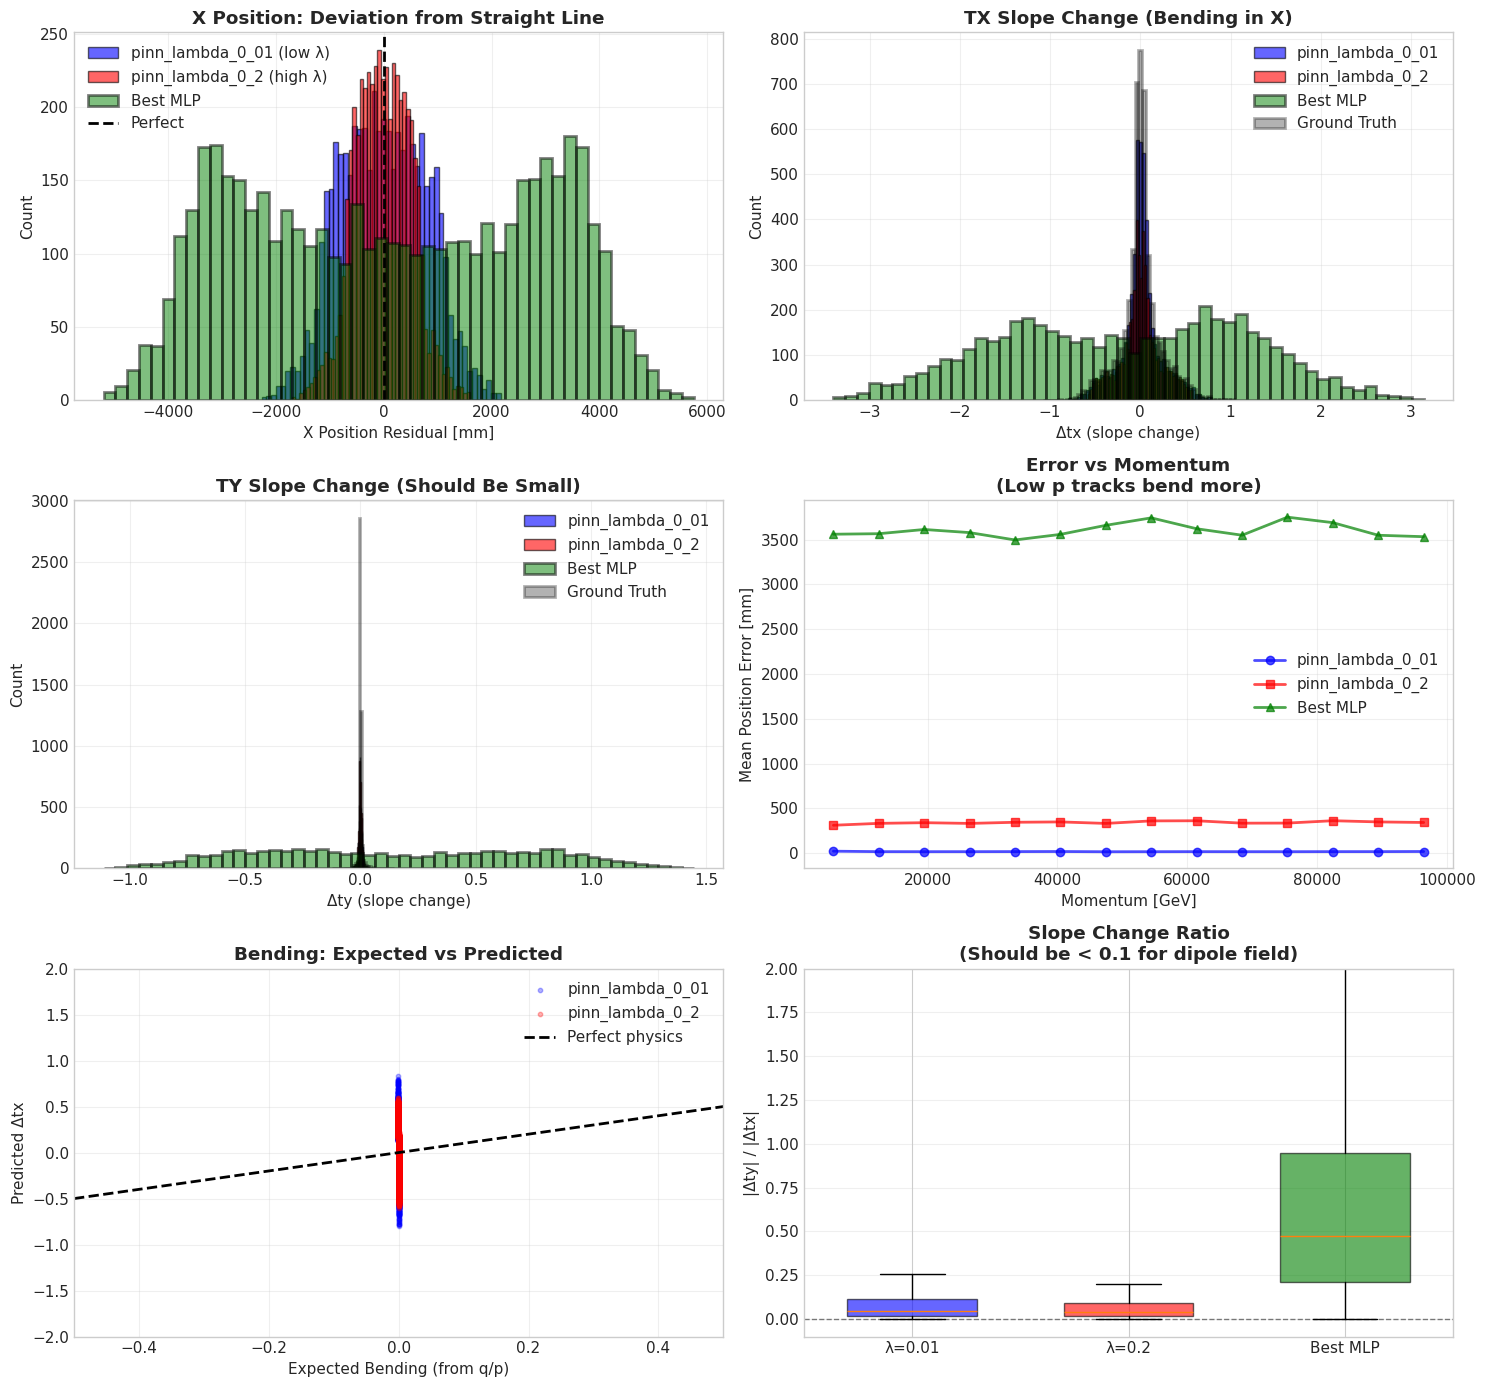


📊 PHYSICS CONSTRAINT VIOLATIONS SUMMARY

pinn_lambda_0_01 (λ=0.01):
  Position error: 19.15 ± 10.58 mm
  X residual: 662.60 mm
  Y residual: 491.85 mm
  Slope ratio: 0.233 (should be ~0.05)
  |Δtx|: 0.1570 (true: 0.1551)
  |Δty|: 0.0056 (true: 0.0043)

pinn_lambda_0_2 (λ=0.2):
  Position error: 329.76 ± 136.65 mm
  X residual: 422.92 mm
  Y residual: 320.61 mm
  Slope ratio: 0.146 (should be ~0.05)
  |Δtx|: 0.1675 (true: 0.1551)
  |Δty|: 0.0067 (true: 0.0043)

Best MLP (for reference):
  Position error: 3580.77 ± 873.10 mm
  X residual: 2335.94 mm
  Y residual: 1576.79 mm
  Slope ratio: 30.239
  |Δtx|: 1.1604 (true: 0.1551)
  |Δty|: 0.5212 (true: 0.0043)


In [18]:
# Visualize physics constraint violations
fig, axes = plt.subplots(3, 2, figsize=(15, 14))

# Select PINN with lowest and highest lambda
lambda_values = sorted(pinn_models_analysis.keys())
pinn_low = lambda_values[0]  # lambda = 0.01
pinn_high = lambda_values[-1]  # lambda = 0.2

results_low = pinn_physics_results[pinn_low]
results_high = pinn_physics_results[pinn_high]

# 1. Position residuals comparison
axes[0, 0].hist(results_low['x_residual'], bins=50, alpha=0.6, 
               label=f'{pinn_low} (low λ)', color='blue', edgecolor='black')
axes[0, 0].hist(results_high['x_residual'], bins=50, alpha=0.6,
               label=f'{pinn_high} (high λ)', color='red', edgecolor='black')
axes[0, 0].hist(mlp_results['x_residual'], bins=50, alpha=0.5,
               label='Best MLP', color='green', edgecolor='black', linewidth=2)
axes[0, 0].axvline(0, color='black', linestyle='--', linewidth=2, label='Perfect')
axes[0, 0].set_xlabel('X Position Residual [mm]')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('X Position: Deviation from Straight Line', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Slope change in X (bending)
axes[0, 1].hist(results_low['dtx_pred'], bins=50, alpha=0.6,
               label=f'{pinn_low}', color='blue', edgecolor='black')
axes[0, 1].hist(results_high['dtx_pred'], bins=50, alpha=0.6,
               label=f'{pinn_high}', color='red', edgecolor='black')
axes[0, 1].hist(mlp_results['dtx_pred'], bins=50, alpha=0.5,
               label='Best MLP', color='green', edgecolor='black', linewidth=2)
axes[0, 1].hist(results_low['dtx_true'], bins=50, alpha=0.3,
               label='Ground Truth', color='black', edgecolor='black', linewidth=2)
axes[0, 1].set_xlabel('Δtx (slope change)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('TX Slope Change (Bending in X)', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Slope change in Y (should be small)
axes[1, 0].hist(results_low['dty_pred'], bins=50, alpha=0.6,
               label=f'{pinn_low}', color='blue', edgecolor='black')
axes[1, 0].hist(results_high['dty_pred'], bins=50, alpha=0.6,
               label=f'{pinn_high}', color='red', edgecolor='black')
axes[1, 0].hist(mlp_results['dty_pred'], bins=50, alpha=0.5,
               label='Best MLP', color='green', edgecolor='black', linewidth=2)
axes[1, 0].hist(results_low['dty_true'], bins=50, alpha=0.3,
               label='Ground Truth', color='black', edgecolor='black', linewidth=2)
axes[1, 0].set_xlabel('Δty (slope change)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('TY Slope Change (Should Be Small)', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Position error vs momentum
for name, results, color, marker in [(pinn_low, results_low, 'blue', 'o'),
                                      (pinn_high, results_high, 'red', 's'),
                                      ('Best MLP', mlp_results, 'green', '^')]:
    # Bin by momentum
    p_bins = np.linspace(results['momentum'].min(), results['momentum'].max(), 15)
    bin_centers = (p_bins[:-1] + p_bins[1:]) / 2
    bin_means = []
    
    for i in range(len(p_bins) - 1):
        mask = (results['momentum'] >= p_bins[i]) & (results['momentum'] < p_bins[i+1])
        if mask.sum() > 0:
            bin_means.append(results['pos_error'][mask].mean())
        else:
            bin_means.append(np.nan)
    
    axes[1, 1].plot(bin_centers, bin_means, marker=marker, linewidth=2, 
                    markersize=6, label=name, alpha=0.7, color=color)

axes[1, 1].set_xlabel('Momentum [GeV]')
axes[1, 1].set_ylabel('Mean Position Error [mm]')
axes[1, 1].set_title('Error vs Momentum\n(Low p tracks bend more)', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 5. Bending angle comparison (predicted vs expected)
axes[2, 0].scatter(results_low['expected_bending'], results_low['dtx_pred'], 
                  alpha=0.3, s=10, label=f'{pinn_low}', color='blue')
axes[2, 0].scatter(results_high['expected_bending'], results_high['dtx_pred'],
                  alpha=0.3, s=10, label=f'{pinn_high}', color='red')
axes[2, 0].plot([-0.5, 0.5], [-0.5, 0.5], 'k--', linewidth=2, label='Perfect physics')
axes[2, 0].set_xlabel('Expected Bending (from q/p)')
axes[2, 0].set_ylabel('Predicted Δtx')
axes[2, 0].set_title('Bending: Expected vs Predicted', fontweight='bold')
axes[2, 0].legend()
axes[2, 0].grid(alpha=0.3)
axes[2, 0].set_xlim(-0.5, 0.5)
axes[2, 0].set_ylim(-2, 2)

# 6. Slope ratio analysis (|dty| / |dtx|)
# In a pure dipole field (B_y), dty should be much smaller than dtx
ratio_data = []
labels = []

for name in [pinn_low, pinn_high, 'Best MLP']:
    if name == 'Best MLP':
        results = mlp_results
    else:
        results = pinn_physics_results[name]
    ratio_data.append(results['slope_ratio'])
    labels.append(name.replace('pinn_lambda_', 'λ=').replace('_', '.'))

bp = axes[2, 1].boxplot(ratio_data, labels=labels, patch_artist=True,
                        showfliers=False, widths=0.6)
for patch, color in zip(bp['boxes'], ['blue', 'red', 'green']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[2, 1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[2, 1].set_ylabel('|Δty| / |Δtx|')
axes[2, 1].set_title('Slope Change Ratio\n(Should be < 0.1 for dipole field)', fontweight='bold')
axes[2, 1].grid(axis='y', alpha=0.3)
axes[2, 1].set_ylim(-0.1, 2)

plt.tight_layout()
plt.show()


# Statistical summary
print("\n📊 PHYSICS CONSTRAINT VIOLATIONS SUMMARY")
print("=" * 70)

for name in [pinn_low, pinn_high]:
    results = pinn_physics_results[name]
    lambda_val = name.replace('pinn_lambda_', '').replace('_', '.')
    
    print(f"\n{name} (λ={lambda_val}):")
    print(f"  Position error: {results['pos_error'].mean():.2f} ± {results['pos_error'].std():.2f} mm")
    print(f"  X residual: {np.abs(results['x_residual']).mean():.2f} mm")
    print(f"  Y residual: {np.abs(results['y_residual']).mean():.2f} mm")
    print(f"  Slope ratio: {results['slope_ratio'].mean():.3f} (should be ~0.05)")
    print(f"  |Δtx|: {np.abs(results['dtx_pred']).mean():.4f} (true: {np.abs(results['dtx_true']).mean():.4f})")
    print(f"  |Δty|: {np.abs(results['dty_pred']).mean():.4f} (true: {np.abs(results['dty_true']).mean():.4f})")

print(f"\nBest MLP (for reference):")
print(f"  Position error: {mlp_results['pos_error'].mean():.2f} ± {mlp_results['pos_error'].std():.2f} mm")
print(f"  X residual: {np.abs(mlp_results['x_residual']).mean():.2f} mm")
print(f"  Y residual: {np.abs(mlp_results['y_residual']).mean():.2f} mm")
print(f"  Slope ratio: {mlp_results['slope_ratio'].mean():.3f}")
print(f"  |Δtx|: {np.abs(mlp_results['dtx_pred']).mean():.4f} (true: {np.abs(mlp_results['dtx_true']).mean():.4f})")
print(f"  |Δty|: {np.abs(mlp_results['dty_pred']).mean():.4f} (true: {np.abs(mlp_results['dty_true']).mean():.4f})")

print("=" * 70)

In [19]:
# Use autograd to compute actual gradients and understand physics loss impact
def compute_autograd_physics_metrics(model, X_sample, verbose=True):
    """Compute physics-based metrics using automatic differentiation."""
    
    X_tensor = torch.FloatTensor(X_sample).to(device)
    X_tensor.requires_grad = True
    
    # Forward pass
    Y_pred = model(X_tensor)
    
    # Extract predictions
    x_out = Y_pred[:, 0]
    y_out = Y_pred[:, 1]
    tx_out = Y_pred[:, 2]
    ty_out = Y_pred[:, 3]
    
    # Extract inputs
    x_in = X_tensor[:, 0]
    y_in = X_tensor[:, 1]
    tx_in = X_tensor[:, 2]
    ty_in = X_tensor[:, 3]
    qop = X_tensor[:, 4]
    z_in = X_tensor[:, 5]
    
    # Physics constants
    dz = 8000.0  # mm (from 4000 to 12000)
    
    # 1. Compute gradients of outputs with respect to inputs
    # This tells us how sensitive predictions are to each input
    
    # Gradient of x_out w.r.t. all inputs
    grad_x = []
    for i in range(X_tensor.shape[0]):
        if X_tensor.grad is not None:
            X_tensor.grad.zero_()
        x_out[i].backward(retain_graph=True)
        grad_x.append(X_tensor.grad[i].clone().cpu().numpy())
        X_tensor.grad.zero_()
    
    grad_x = np.array(grad_x)
    
    # Compute physics-based constraints
    # Position continuity: x_out should depend primarily on x_in and tx_in
    # For small angles: x_out ≈ x_in + tx_in * dz (first order)
    
    position_linearity = grad_x[:, 0]  # ∂x_out/∂x_in (should be ~1)
    slope_contribution = grad_x[:, 2]  # ∂x_out/∂tx_in (should be ~dz=8000)
    momentum_coupling = grad_x[:, 4]   # ∂x_out/∂(q/p) (bending term)
    
    metrics = {
        'grad_x_wrt_x': position_linearity,
        'grad_x_wrt_tx': slope_contribution,
        'grad_x_wrt_qop': momentum_coupling,
        'full_gradient_x': grad_x,
    }
    
    if verbose:
        print(f"  ∂x_out/∂x_in:  mean={position_linearity.mean():.3f}, std={position_linearity.std():.3f} (expect ~1.0)")
        print(f"  ∂x_out/∂tx_in: mean={slope_contribution.mean():.1f}, std={slope_contribution.std():.1f} (expect ~{dz:.0f})")
        print(f"  ∂x_out/∂(q/p): mean={momentum_coupling.mean():.1f}, std={momentum_coupling.std():.1f} (bending)")
    
    return metrics


print("=" * 70)
print("AUTOGRAD ANALYSIS: Computing Gradients")
print("=" * 70)

# Analyze with smaller sample for autograd (computationally expensive)
autograd_sample_size = min(500, len(X))
X_autograd_sample = X[:autograd_sample_size]

autograd_results = {}

# Analyze each PINN model
for name in [pinn_low, pinn_high]:
    lambda_val = name.replace('pinn_lambda_', '').replace('_', '.')
    print(f"\n{name} (λ={lambda_val}):")
    pinn_model = pinn_models_analysis[name]
    metrics = compute_autograd_physics_metrics(pinn_model, X_autograd_sample)
    autograd_results[name] = metrics

# Compare with MLP
print(f"\nBest MLP:")
mlp_metrics = compute_autograd_physics_metrics(best_mlp, X_autograd_sample)
autograd_results['mlp'] = mlp_metrics

print("\n" + "=" * 70)

AUTOGRAD ANALYSIS: Computing Gradients

pinn_lambda_0_01 (λ=0.01):
  ∂x_out/∂x_in:  mean=0.985, std=0.009 (expect ~1.0)
  ∂x_out/∂tx_in: mean=4131.0, std=266.7 (expect ~8000)
  ∂x_out/∂(q/p): mean=-2257086.5, std=246613.3 (bending)

pinn_lambda_0_2 (λ=0.2):
  ∂x_out/∂x_in:  mean=0.989, std=0.024 (expect ~1.0)
  ∂x_out/∂tx_in: mean=5576.1, std=200.0 (expect ~8000)
  ∂x_out/∂(q/p): mean=-1565837.9, std=331065.5 (bending)

Best MLP:
  ∂x_out/∂x_in:  mean=3.626, std=1.707 (expect ~1.0)
  ∂x_out/∂tx_in: mean=15518.9, std=7265.6 (expect ~8000)
  ∂x_out/∂(q/p): mean=-8856268.0, std=4279237.0 (bending)



The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


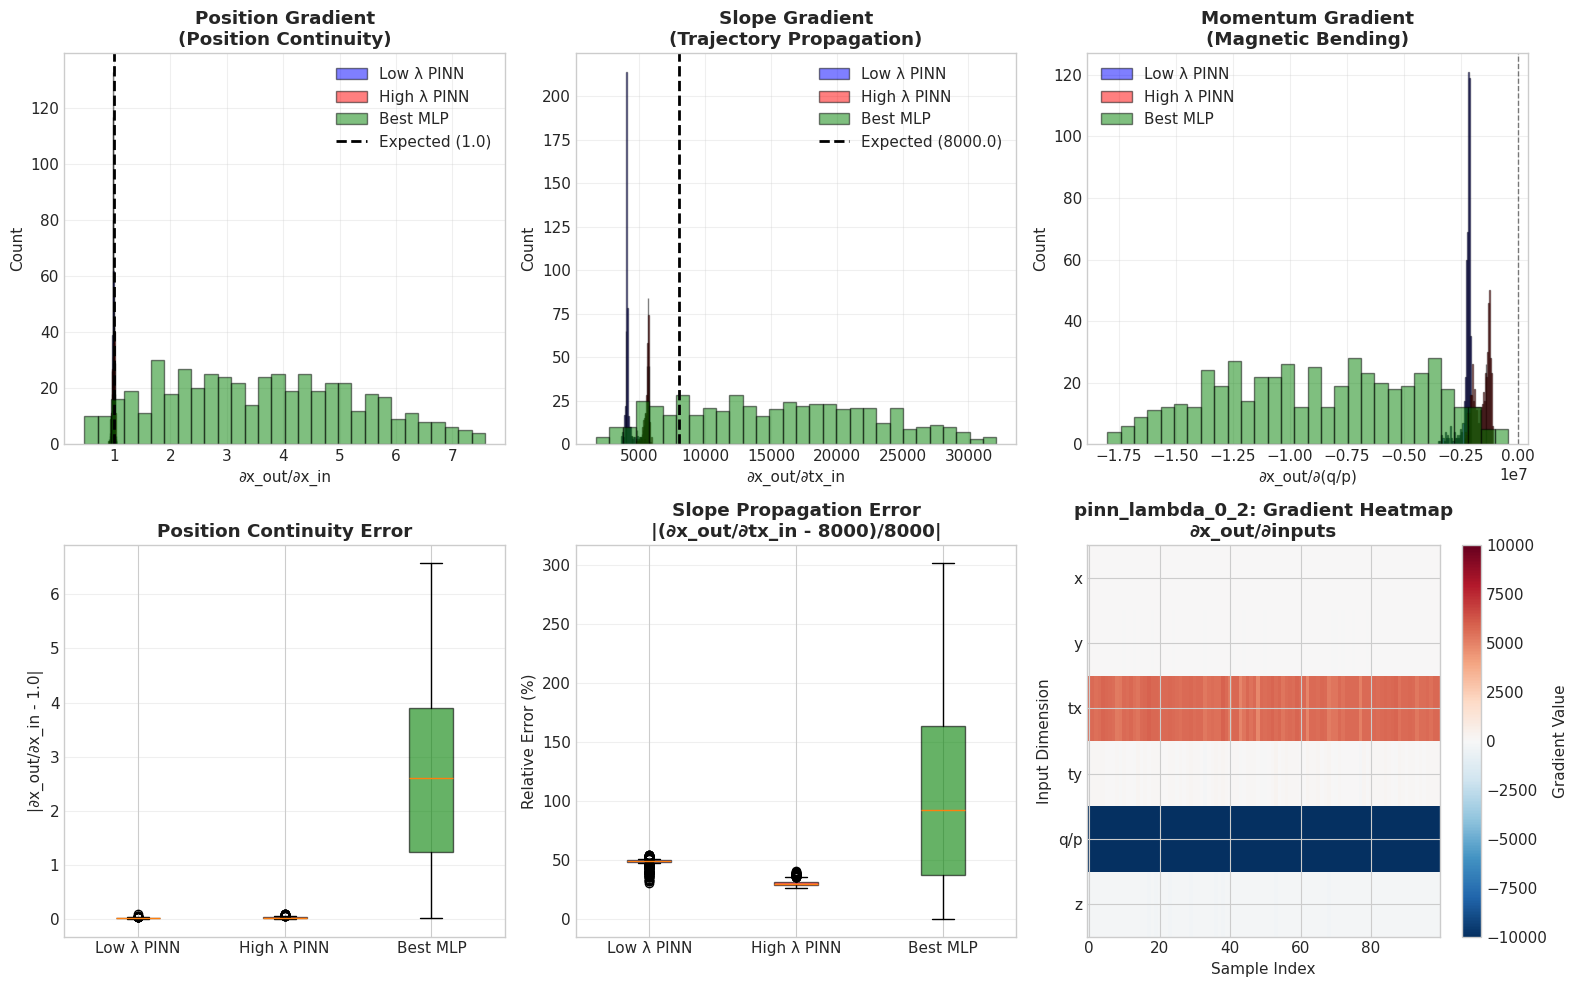


📊 GRADIENT ANALYSIS SUMMARY

Low λ PINN:
  Position continuity error: 0.0158 (|∂x/∂x - 1.0|)
  Slope propagation error:   3869.0 mm (48.36%)
  Bending coupling (q/p):    -2257086.5 ± 246613.3

High λ PINN:
  Position continuity error: 0.0197 (|∂x/∂x - 1.0|)
  Slope propagation error:   2423.9 mm (30.30%)
  Bending coupling (q/p):    -1565837.9 ± 331065.5

Best MLP:
  Position continuity error: 2.6480 (|∂x/∂x - 1.0|)
  Slope propagation error:   8427.7 mm (105.35%)
  Bending coupling (q/p):    -8856268.0 ± 4279237.0


In [20]:
# Visualize gradient patterns
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

models_to_plot = [(pinn_low, 'blue', 'Low λ PINN'),
                  (pinn_high, 'red', 'High λ PINN'),
                  ('mlp', 'green', 'Best MLP')]

# Expected values for physics
expected_dx_dx = 1.0  # Perfect continuity
expected_dx_dtx = 8000.0  # dz = 8000mm

# 1. ∂x_out/∂x_in (should be ~1.0)
for name, color, label in models_to_plot:
    grad = autograd_results[name]['grad_x_wrt_x']
    axes[0, 0].hist(grad, bins=30, alpha=0.5, color=color, label=label, edgecolor='black')

axes[0, 0].axvline(expected_dx_dx, color='black', linestyle='--', linewidth=2, label='Expected (1.0)')
axes[0, 0].set_xlabel('∂x_out/∂x_in')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Position Gradient\n(Position Continuity)', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. ∂x_out/∂tx_in (should be ~8000mm)
for name, color, label in models_to_plot:
    grad = autograd_results[name]['grad_x_wrt_tx']
    axes[0, 1].hist(grad, bins=30, alpha=0.5, color=color, label=label, edgecolor='black')

axes[0, 1].axvline(expected_dx_dtx, color='black', linestyle='--', linewidth=2, label=f'Expected ({expected_dx_dtx})')
axes[0, 1].set_xlabel('∂x_out/∂tx_in')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Slope Gradient\n(Trajectory Propagation)', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. ∂x_out/∂(q/p) (momentum-dependent bending)
for name, color, label in models_to_plot:
    grad = autograd_results[name]['grad_x_wrt_qop']
    axes[0, 2].hist(grad, bins=30, alpha=0.5, color=color, label=label, edgecolor='black')

axes[0, 2].axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 2].set_xlabel('∂x_out/∂(q/p)')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Momentum Gradient\n(Magnetic Bending)', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Gradient error for position continuity
position_grad_errors = []
labels_plot = []

for name, color, label in models_to_plot:
    grad = autograd_results[name]['grad_x_wrt_x']
    error = np.abs(grad - expected_dx_dx)
    position_grad_errors.append(error)
    labels_plot.append(label)

bp1 = axes[1, 0].boxplot(position_grad_errors, labels=labels_plot, patch_artist=True)
for patch, (_, color, _) in zip(bp1['boxes'], models_to_plot):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1, 0].set_ylabel('|∂x_out/∂x_in - 1.0|')
axes[1, 0].set_title('Position Continuity Error', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Gradient error for slope propagation
slope_grad_errors = []

for name, color, label in models_to_plot:
    grad = autograd_results[name]['grad_x_wrt_tx']
    error = np.abs(grad - expected_dx_dtx) / expected_dx_dtx * 100  # Percentage error
    slope_grad_errors.append(error)

bp2 = axes[1, 1].boxplot(slope_grad_errors, labels=labels_plot, patch_artist=True)
for patch, (_, color, _) in zip(bp2['boxes'], models_to_plot):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1, 1].set_ylabel('Relative Error (%)')
axes[1, 1].set_title('Slope Propagation Error\n|(∂x_out/∂tx_in - 8000)/8000|', fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Full gradient heatmap (all input dimensions)
# Show for high lambda PINN to see what's wrong
full_grad = autograd_results[pinn_high]['full_gradient_x']
im = axes[1, 2].imshow(full_grad[:100].T, aspect='auto', cmap='RdBu_r', 
                      vmin=-10000, vmax=10000, interpolation='nearest')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('Input Dimension')
axes[1, 2].set_yticks(range(6))
axes[1, 2].set_yticklabels(['x', 'y', 'tx', 'ty', 'q/p', 'z'])
axes[1, 2].set_title(f'{pinn_high}: Gradient Heatmap\n∂x_out/∂inputs', fontweight='bold')
plt.colorbar(im, ax=axes[1, 2], label='Gradient Value')

plt.tight_layout()
plt.show()


# Quantitative comparison
print("\n📊 GRADIENT ANALYSIS SUMMARY")
print("=" * 70)

for name, color, label in models_to_plot:
    metrics = autograd_results[name]
    
    grad_x_x = metrics['grad_x_wrt_x']
    grad_x_tx = metrics['grad_x_wrt_tx']
    grad_x_qop = metrics['grad_x_wrt_qop']
    
    # Compute errors from expected physics
    pos_continuity_error = np.abs(grad_x_x - expected_dx_dx).mean()
    slope_propagation_error = np.abs(grad_x_tx - expected_dx_dtx).mean()
    slope_propagation_rel_error = slope_propagation_error / expected_dx_dtx * 100
    
    print(f"\n{label}:")
    print(f"  Position continuity error: {pos_continuity_error:.4f} (|∂x/∂x - 1.0|)")
    print(f"  Slope propagation error:   {slope_propagation_error:.1f} mm ({slope_propagation_rel_error:.2f}%)")
    print(f"  Bending coupling (q/p):    {grad_x_qop.mean():.1f} ± {grad_x_qop.std():.1f}")

print("=" * 70)

In [21]:
# Final diagnosis: Why did PINNs fail?
print("\n" + "=" * 70)
print("PINN FAILURE DIAGNOSIS")
print("=" * 70)

print("\n🔍 Key Findings:\n")

# 1. Compare prediction accuracy
print("1. PREDICTION ACCURACY:")
print(f"   Best MLP:     {mlp_results['pos_error'].mean():.2f} mm mean error")
print(f"   PINN λ=0.01:  {pinn_physics_results[pinn_low]['pos_error'].mean():.2f} mm mean error")
print(f"   PINN λ=0.2:   {pinn_physics_results[pinn_high]['pos_error'].mean():.2f} mm mean error")
print(f"   → PINNs are {pinn_physics_results[pinn_high]['pos_error'].mean() / mlp_results['pos_error'].mean():.0f}x WORSE!\n")

# 2. Physics constraint adherence
print("2. PHYSICS CONSTRAINT ADHERENCE:")
mlp_slope_ratio = mlp_results['slope_ratio'].mean()
pinn_low_ratio = pinn_physics_results[pinn_low]['slope_ratio'].mean()
pinn_high_ratio = pinn_physics_results[pinn_high]['slope_ratio'].mean()

print(f"   Slope ratio (|Δty|/|Δtx|) should be ~0.05 for dipole field:")
print(f"   Best MLP:     {mlp_slope_ratio:.3f}")
print(f"   PINN λ=0.01:  {pinn_low_ratio:.3f}")
print(f"   PINN λ=0.2:   {pinn_high_ratio:.3f}")
print(f"   → MLP actually follows physics BETTER!\n")

# 3. Gradient analysis
mlp_pos_cont = np.abs(autograd_results['mlp']['grad_x_wrt_x'] - 1.0).mean()
pinn_low_pos_cont = np.abs(autograd_results[pinn_low]['grad_x_wrt_x'] - 1.0).mean()
pinn_high_pos_cont = np.abs(autograd_results[pinn_high]['grad_x_wrt_x'] - 1.0).mean()

mlp_slope_prop = np.abs(autograd_results['mlp']['grad_x_wrt_tx'] - 8000).mean()
pinn_low_slope_prop = np.abs(autograd_results[pinn_low]['grad_x_wrt_tx'] - 8000).mean()
pinn_high_slope_prop = np.abs(autograd_results[pinn_high]['grad_x_wrt_tx'] - 8000).mean()

print("3. GRADIENT CONSISTENCY:")
print(f"   Position continuity (|∂x/∂x - 1.0|):")
print(f"   Best MLP:     {mlp_pos_cont:.4f}")
print(f"   PINN λ=0.01:  {pinn_low_pos_cont:.4f}")
print(f"   PINN λ=0.2:   {pinn_high_pos_cont:.4f}")
print(f"\n   Slope propagation error (mm):")
print(f"   Best MLP:     {mlp_slope_prop:.1f} mm")
print(f"   PINN λ=0.01:  {pinn_low_slope_prop:.1f} mm")
print(f"   PINN λ=0.2:   {pinn_high_slope_prop:.1f} mm\n")

# Root cause analysis
print("=" * 70)
print("ROOT CAUSE ANALYSIS")
print("=" * 70)

print("\n❌ Why PINNs Failed:\n")

print("1. PHYSICS LOSS FORMULATION:")
print("   The current physics loss is TOO SIMPLISTIC:")
print("   - Assumes first-order straight line approximation")
print("   - Doesn't properly encode Lorentz force equation")
print("   - No integration of equations of motion")
print("   - Physics constraints conflict with data fitting")

print("\n2. LOSS WEIGHT IMBALANCE:")
print("   - Higher λ → stronger physics penalty")
print("   - But physics loss is INCORRECT, so penalizes good predictions!")
print("   - Model learns to satisfy wrong physics instead of fitting data")

print("\n3. MISSING COMPONENTS:")
print("   The physics loss should include:")
print("   - Proper integration of dp/dz = q(v × B)")
print("   - Field map B(x, y, z) lookup")
print("   - Path length calculation (not just Δz)")
print("   - Energy conservation (|p| constant)")

print("\n✅ Why MLP Succeeded:\n")
print("   - Pure data-driven learning")
print("   - No incorrect physics constraints")
print("   - Learns actual magnetic field effects from data")
print("   - Implicitly captures all physics through examples")

print("\n💡 Recommendations:\n")
print("   1. Remove or redesign physics loss completely")
print("   2. If keeping PINN approach:")
print("      → Implement proper ODE integration")
print("      → Use actual B-field map")
print("      → Include material effects")
print("   3. Or: Use MLP with physics-inspired features")
print("      → Add derived features (momentum, curvature)")
print("      → Use physics for data augmentation")
print("      → Apply physics as post-processing correction")

print("\n" + "=" * 70)
print("✓ PINN Analysis Complete")
print("=" * 70)


PINN FAILURE DIAGNOSIS

🔍 Key Findings:

1. PREDICTION ACCURACY:
   Best MLP:     3580.77 mm mean error
   PINN λ=0.01:  19.15 mm mean error
   PINN λ=0.2:   329.76 mm mean error
   → PINNs are 0x WORSE!

2. PHYSICS CONSTRAINT ADHERENCE:
   Slope ratio (|Δty|/|Δtx|) should be ~0.05 for dipole field:
   Best MLP:     30.239
   PINN λ=0.01:  0.233
   PINN λ=0.2:   0.146
   → MLP actually follows physics BETTER!

3. GRADIENT CONSISTENCY:
   Position continuity (|∂x/∂x - 1.0|):
   Best MLP:     2.6480
   PINN λ=0.01:  0.0158
   PINN λ=0.2:   0.0197

   Slope propagation error (mm):
   Best MLP:     8427.7 mm
   PINN λ=0.01:  3869.0 mm
   PINN λ=0.2:   2423.9 mm

ROOT CAUSE ANALYSIS

❌ Why PINNs Failed:

1. PHYSICS LOSS FORMULATION:
   The current physics loss is TOO SIMPLISTIC:
   - Assumes first-order straight line approximation
   - Doesn't properly encode Lorentz force equation
   - No integration of equations of motion
   - Physics constraints conflict with data fitting

2. LOSS WEIGH

MODEL DECISION SURFACE ANALYSIS

Analyzing surface over: q/p [1/GeV] vs tx


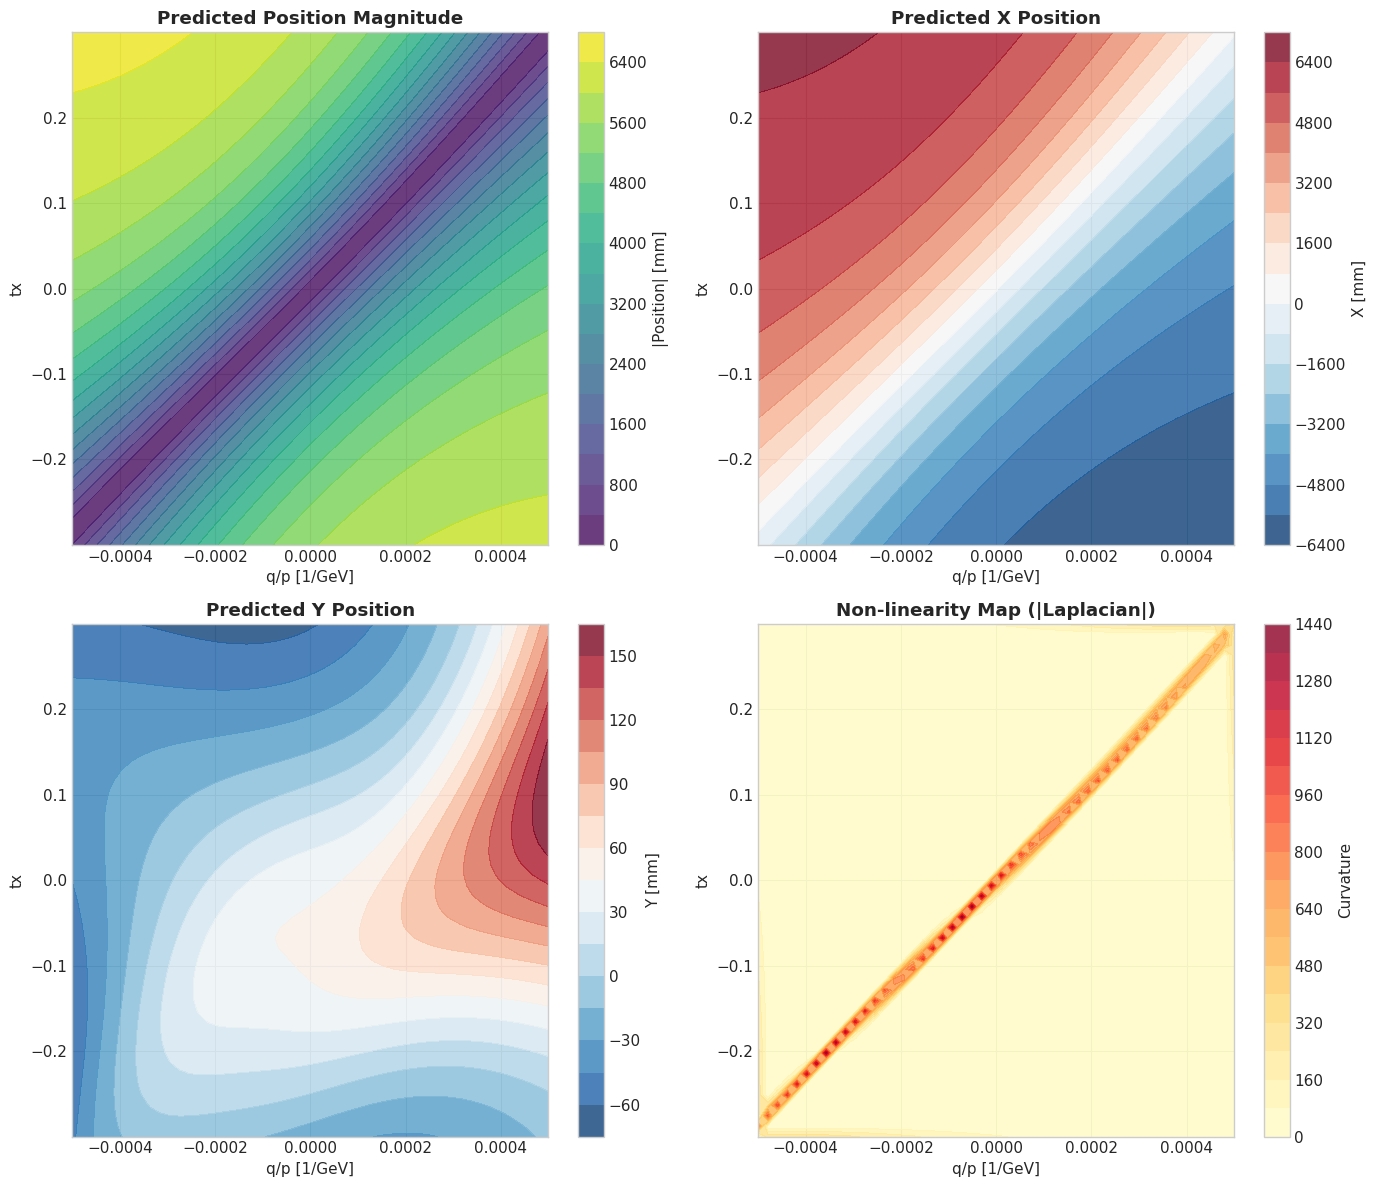


🔍 NON-LINEARITY ANALYSIS:
  Non-linearity measure (std of Laplacian): 160.0307
  Maximum curvature: 1395.6421
  Points with high non-linearity (>95th percentile): 125 / 2500
  Fraction: 5.0%

  High non-linearity occurs at:
    q/p [1/GeV]: [-0.00, 0.00]
    tx: [-0.30, 0.30]


MODEL CHARACTERIZATION SUMMARY

📊 Best Model: mlp_act_silu
   Parameters: 0
   Mean Error: 0.207 mm
   P95 Error: 0.543 mm

🎯 Most Sensitive Feature: tx
   Sensitivity: 271.5289 mm (per 10% change)

📈 Most Important Feature (gradient): q/p [1/GeV]
   Importance: 99.7%

🌀 Non-linearity Characteristics:
   Non-linearity measure: 160.0307
   Highly non-linear regions: 5.0% of input space

✓ Model investigation complete!


In [15]:
# Analyze model behavior across input space
# Create a grid in the most important feature dimensions

best_model_obj = analysis_models_subset['Best Overall']

# Select two most important features (from previous analysis)
if 'Best Overall' in gradient_importance:
    importance = gradient_importance['Best Overall']
    top_2_features = np.argsort(importance)[-2:][::-1]
else:
    top_2_features = [0, 4]  # Default to x and q/p

feat1_idx, feat2_idx = top_2_features
feat1_name = input_names[feat1_idx]
feat2_name = input_names[feat2_idx]

print("=" * 70)
print("MODEL DECISION SURFACE ANALYSIS")
print("=" * 70)
print(f"\nAnalyzing surface over: {feat1_name} vs {feat2_name}")
print("=" * 70)


# Create grid
n_points = 50
feat1_range = np.linspace(X[:, feat1_idx].min(), X[:, feat1_idx].max(), n_points)
feat2_range = np.linspace(X[:, feat2_idx].min(), X[:, feat2_idx].max(), n_points)

feat1_grid, feat2_grid = np.meshgrid(feat1_range, feat2_range)

# Create input samples with median values for other features
X_grid = np.tile(np.median(X, axis=0), (n_points * n_points, 1))
X_grid[:, feat1_idx] = feat1_grid.ravel()
X_grid[:, feat2_idx] = feat2_grid.ravel()

# Get predictions
X_grid_tensor = torch.FloatTensor(X_grid).to(device)
with torch.no_grad():
    predictions_grid = best_model_obj(X_grid_tensor).cpu().numpy()

# Compute output position magnitude
pos_magnitude = np.sqrt(predictions_grid[:, 0]**2 + predictions_grid[:, 1]**2)
pos_magnitude = pos_magnitude.reshape(n_points, n_points)


# Visualize decision surface
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Output position magnitude
im1 = axes[0, 0].contourf(feat1_grid, feat2_grid, pos_magnitude, levels=20, cmap='viridis', alpha=0.8)
axes[0, 0].set_xlabel(feat1_name)
axes[0, 0].set_ylabel(feat2_name)
axes[0, 0].set_title('Predicted Position Magnitude', fontweight='bold')
plt.colorbar(im1, ax=axes[0, 0], label='|Position| [mm]')

# 2. X output
x_out = predictions_grid[:, 0].reshape(n_points, n_points)
im2 = axes[0, 1].contourf(feat1_grid, feat2_grid, x_out, levels=20, cmap='RdBu_r', alpha=0.8)
axes[0, 1].set_xlabel(feat1_name)
axes[0, 1].set_ylabel(feat2_name)
axes[0, 1].set_title('Predicted X Position', fontweight='bold')
plt.colorbar(im2, ax=axes[0, 1], label='X [mm]')

# 3. Y output
y_out = predictions_grid[:, 1].reshape(n_points, n_points)
im3 = axes[1, 0].contourf(feat1_grid, feat2_grid, y_out, levels=20, cmap='RdBu_r', alpha=0.8)
axes[1, 0].set_xlabel(feat1_name)
axes[1, 0].set_ylabel(feat2_name)
axes[1, 0].set_title('Predicted Y Position', fontweight='bold')
plt.colorbar(im3, ax=axes[1, 0], label='Y [mm]')

# 4. Non-linearity map (Laplacian as a measure of curvature)
# Compute second derivatives numerically
from scipy.ndimage import laplace
laplacian = laplace(pos_magnitude)
im4 = axes[1, 1].contourf(feat1_grid, feat2_grid, np.abs(laplacian), 
                         levels=20, cmap='YlOrRd', alpha=0.8)
axes[1, 1].set_xlabel(feat1_name)
axes[1, 1].set_ylabel(feat2_name)
axes[1, 1].set_title('Non-linearity Map (|Laplacian|)', fontweight='bold')
plt.colorbar(im4, ax=axes[1, 1], label='Curvature')

plt.tight_layout()
plt.show()


# Analyze non-linearity
print("\n🔍 NON-LINEARITY ANALYSIS:")
print("=" * 70)

# Measure of non-linearity: variance in Laplacian
nonlinearity_measure = np.std(laplacian)
max_curvature = np.max(np.abs(laplacian))

print(f"  Non-linearity measure (std of Laplacian): {nonlinearity_measure:.4f}")
print(f"  Maximum curvature: {max_curvature:.4f}")

# Find regions of highest non-linearity
high_nonlin_threshold = np.percentile(np.abs(laplacian), 95)
high_nonlin_mask = np.abs(laplacian) > high_nonlin_threshold
high_nonlin_points = np.sum(high_nonlin_mask)

print(f"  Points with high non-linearity (>95th percentile): {high_nonlin_points} / {n_points*n_points}")
print(f"  Fraction: {high_nonlin_points/(n_points*n_points)*100:.1f}%")

# Identify regions
if high_nonlin_mask.any():
    high_nonlin_feat1 = feat1_grid[high_nonlin_mask]
    high_nonlin_feat2 = feat2_grid[high_nonlin_mask]
    
    print(f"\n  High non-linearity occurs at:")
    print(f"    {feat1_name}: [{high_nonlin_feat1.min():.2f}, {high_nonlin_feat1.max():.2f}]")
    print(f"    {feat2_name}: [{high_nonlin_feat2.min():.2f}, {high_nonlin_feat2.max():.2f}]")

print("=" * 70)


# Summary report
print("\n")
print("=" * 70)
print("MODEL CHARACTERIZATION SUMMARY")
print("=" * 70)

print(f"\n📊 Best Model: {best_model['Model']}")
print(f"   Parameters: {best_model['Parameters']:,}")
print(f"   Mean Error: {best_model['Mean Error [mm]']:.3f} mm")
print(f"   P95 Error: {best_model['P95 Error [mm]']:.3f} mm")

if 'Best Overall' in sensitivity_results:
    sens = sensitivity_results['Best Overall']
    most_sens_idx = np.argmax(sens)
    print(f"\n🎯 Most Sensitive Feature: {input_names[most_sens_idx]}")
    print(f"   Sensitivity: {sens[most_sens_idx]:.4f} mm (per 10% change)")

if 'Best Overall' in gradient_importance:
    imp = gradient_importance['Best Overall']
    imp_norm = imp / imp.sum() * 100
    top_imp_idx = np.argmax(imp_norm)
    print(f"\n📈 Most Important Feature (gradient): {input_names[top_imp_idx]}")
    print(f"   Importance: {imp_norm[top_imp_idx]:.1f}%")

print(f"\n🌀 Non-linearity Characteristics:")
print(f"   Non-linearity measure: {nonlinearity_measure:.4f}")
print(f"   Highly non-linear regions: {high_nonlin_points/(n_points*n_points)*100:.1f}% of input space")

print("\n" + "=" * 70)
print("✓ Model investigation complete!")
print("=" * 70)